In [ ]:
spark.stop()

# Set paths

DEVEL_SRC must contain the directory use-cases and pykhaos

In [2]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)
    
import sys

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "nb_myvf_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20200811-094843 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/nb_myvf_20200811_094843.log


<IPython.core.display.Javascript object>

In [3]:
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, avg as sql_avg, lpad, struct, count as sql_count, lag, lit, min as sql_min, max as sql_max, collect_list, udf, when, desc, asc, to_date, create_map, sum as sql_sum, length, concat_ws, regexp_replace, split
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
from itertools import chain
from churn.datapreparation.general.data_loader import get_unlabeled_car, get_port_requests_table, get_numclients_under_analysis
from churn.utils.constants import PORT_TABLE_NAME
from churn.utils.udf_manager import Funct_to_UDF
from pyspark.sql.functions import substring, datediff, row_number

import datetime as dt
from pyspark.sql.functions import from_unixtime,unix_timestamp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Functions

## Start spark context

In [4]:
from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context = get_spark_session("nb_myvf")
sc.setLogLevel('WARN')

# ADOBE DATA

In [ ]:

from churn_nrt.src.data.myvf_data import MyVFdata

df_myvf = MyVFdata(spark, "app").get_module("20191115", save=False, save_others=False)

In [ ]:
cols_permanencia = [col_ for col_ in df_myvf.columns if "permanencia" in col_]
df_myvf.select(*(["msisdn"] + cols_permanencia)).show()

In [ ]:
spark.read.table("raw_es.customerprofilecar_adobe_web").select("MSISDN").distinct().show()

# MAPA DE VOLUMENES

In [4]:
df = (spark.read.table("raw_es.customerprofilecar_adobe_web")               
    .withColumn("yearmonth", concat(col('year'), lpad(col('month'), 2, '0'))).groupby("day").pivot("yearmonth").agg(sql_count("*").alias("count")).sort(desc("day")).fillna(0))
 
from churn_nrt.src.utils.date_functions import months_range
      
m_range= months_range("201905", "202004")
      
for mm in m_range:
    if mm not in df.columns:
        df = df.withColumn(mm, lit(0))

df.select(*(["day"] + m_range)).show(31)


+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|day| 201905| 201906| 201907| 201908| 201909| 201910| 201911| 201912| 202001| 202002| 202003| 202004|
+---+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| 31|1480393|      0|2098577|1178407|      0|1821900|      0|1379217|1888996|      0|2515397|      0|
| 30|      0|1082202|2168684|1858539|2358861|2004729|1265086|2020313|1930731|      0|2433686|      0|
| 29|      0|1111782|2320305|2055337|1123599|2108795|2058090|1322016|2123797|      0|1383809|      0|
| 28|      0|1796033|1089654|2023495|1145516|2197113|2330866|1443785|2130353|      0|1519704|      0|
| 27|      0|1716320|1206382|2240834|1784079|1170048|2208423|2286863|2243275|2028573|2110593|      0|
| 26|      0|1953696|1741898|2325528|2027441|1010750|2137783|2248132|1042232|2115321|2247715|      0|
| 25|      0|1976951|1936261|1115765|2252495|1786392|2209238|1159332|1108596|22241

# MSISDNS unicos por dia

In [9]:
df = (spark.read.table("raw_es.customerprofilecar_adobe_web").drop_duplicates(["msisdn", "year", "month", "day"])     
    .withColumn("yearmonth", concat(col('year'), lpad(col('month'), 2, '0'))).groupby("day").pivot("yearmonth").agg(sql_count("*").alias("count")).sort(desc("day")).fillna(0))
 
from churn_nrt.src.utils.date_functions import months_range
      
m_range= months_range("201905", "202004")
      
for mm in m_range:
    if mm not in df.columns:
        df = df.withColumn(mm, lit(0))

df.select(*(["day"] + m_range)).show(31)

+---+------+------+------+------+------+------+------+------+------+------+------+------+
|day|201905|201906|201907|201908|201909|201910|201911|201912|202001|202002|202003|202004|
+---+------+------+------+------+------+------+------+------+------+------+------+------+
| 31|     1|     0| 60097| 31077|     0| 55947|     0| 38257| 52099|     0| 60769|     0|
| 30|     0| 29494| 61372| 54562| 70422| 52721| 31467| 56430| 51356|     0| 62654|     0|
| 29|     0| 29475| 67929| 59461| 28771| 55416| 57856| 33001| 55815|     0| 28988|     0|
| 28|     0| 50536| 26851| 55289| 28702| 60489| 62086| 35863| 59319|     0| 32347|     0|
| 27|     0| 48727| 28949| 60241| 50701| 29446| 58253| 63829| 66078| 48518| 51561|     0|
| 26|     0| 55662| 48322| 66841| 56176| 22079| 57909| 60554| 27100| 52359| 53121|     0|
| 25|     0| 55970| 51705| 28953| 63895| 52174| 60525| 26436| 29077| 51768| 61088|     0|
| 24|     0| 50037| 46710| 29109| 61739| 48739| 28264| 33203| 49785| 54591| 53465|     0|
| 23|     

In [10]:
df = (spark.read.table("raw_es.customerprofilecar_adobe_web").withColumn("flag_permanencia", when(col("Pages").rlike("permanencia"), 1).otherwise(0))
    .where(col("flag_permanencia")==1).drop_duplicates(["msisdn", "year", "month", "day"])         
    .withColumn("yearmonth", concat(col('year'), lpad(col('month'), 2, '0'))).groupby("day").pivot("yearmonth").agg(sql_count("*").alias("count")).sort(desc("day")).fillna(0))
 
from churn_nrt.src.utils.date_functions import months_range
      
m_range= months_range("201905", "202004")
      
for mm in m_range:
    if mm not in df.columns:
        df = df.withColumn(mm, lit(0))

df.select(*(["day"] + m_range)).show(31)




+---+------+------+------+------+------+------+------+------+------+------+------+------+
|day|201905|201906|201907|201908|201909|201910|201911|201912|202001|202002|202003|202004|
+---+------+------+------+------+------+------+------+------+------+------+------+------+
| 31|     1|     0|  2956|  1430|     0|  2775|     0|  1653|  2245|     0|  2152|     0|
| 30|     0|  1492|  3107|  2709|  3347|  3058|  1437|  2649|  2334|     0|  2077|     0|
| 29|     0|  1437|  3329|  3120|  1303|  2996|  2524|  1462|  2551|     0|   871|     0|
| 28|     0|  2607|  1257|  3011|  1303|  3310|  2642|  1597|  2832|     0|  1051|     0|
| 27|     0|  2644|  1304|  3394|  2380|  1429|  2924|  2967|  3155|  2261|  1579|     0|
| 26|     0|  3319|  2256|  3578|  2780|   807|  3042|  2882|  1166|  2474|  1787|     0|
| 25|     0|  3284|  2592|  1269|  3373|  2574|  3227|  1100|  1245|  2482|  2075|     0|
| 24|     0|  2783|  2445|  1153|  3375|  2546|  1356|  1401|  2273|  2595|  1750|     0|
| 23|     

In [ ]:
(spark.read.table("raw_es.customerprofilecar_adobe_web").where( (col("year")==2019) & (col("month")==6)).groupby("year", "month", "day").agg(sql_count("*").alias("count")).sort(desc("year"), desc("month"), desc("day")).show(35))


In [ ]:
(spark.read.table("raw_es.customerprofilecar_adobe_web").groupby("year", "month").agg(sql_count("*").alias("count")).sort(desc("year"), desc("month")).show())


In [ ]:
(spark.read.table("raw_es.customerprofilecar_adobe_sections").groupby("year", "month").agg(sql_count("*").alias("count")).sort(desc("year"), desc("month")).show())
# +----+-----+--------+
# |year|month|   count|
# +----+-----+--------+
# |2020|    2|29266225|
# |2020|    1| 5933887|
# |2019|   12|57171062|
# |2019|   11|47712516|
# |2019|   10|41964765|
# |2019|    9|40758940|
# |2019|    8|52132198|
# |2019|    7|46848030|
# |2019|    6|25857755|
# |2019|    5|    1223|
# +----+-----+--------+





In [ ]:
start_time_total = time.time()
import pandas as pd
final_filename = "/var/SP/data/home/csanc109/data/myvf_web_sections_{}_{}.xlsx".format("201909", dt.datetime.now().strftime("%Y%m%d_%H%M%S"))
writer = pd.ExcelWriter(final_filename, engine='xlsxwriter')
workbook = writer.book

df1.to_excel(writer, sheet_name="page", startrow=7, startcol=0, index=True, header=True)
df2.to_excel(writer, sheet_name="sec_sub", startrow=7, startcol=0, index=True, header=True)
df3.to_excel(writer, sheet_name="sec_sub_page", startrow=7, startcol=0, index=True, header=True)
writer.save()

print("Ended! - elapsed {} minutes".format( (time.time() - start_time_total)/60.0))


In [ ]:
closing_day = "20190831"

from churn_nrt.src.utils.date_functions import move_date_n_days

df_net = (spark.read.table("raw_es.customerprofilecar_adobe_web")#.where(col("msisdn").isin("34694136569", "34601472008", "34601053588"))
                      .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) <= closing_day)
                      .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) >= move_date_n_days(closing_day, n=-30))
                     .drop("service_processed_at", "service_file_id", "year", "month", "day")
                     .withColumn("msisdn", col("MSISDN").substr(3, 9)))


func_date = udf(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime("%Y%m%d"), StringType())

df_net = df_net.withColumn('date_', func_date(col('Date'))).drop("Date")

stages_name = ["section", "subsection", "page_name"]

df_net = df_net.withColumn('Pages', regexp_replace('Pages', ', ', '_'))
df_net = df_net.withColumn('Pages', regexp_replace('Pages', '-', '_'))
df_net = df_net.withColumn('Pages', regexp_replace('Pages', ' ', '_'))
# subsection exist with both names - join them
df_net = df_net.withColumn('Pages', regexp_replace('Pages', 'configuracion_notificacione_push', 'configuracion_notificaciones_push'))

for ii, col_ in enumerate(stages_name):
    if col_ == "section":
        # Do not split if Pages is an url
        df_net = df_net.withColumn(col_, when(~col("Pages").rlike("^https://"), split("Pages", ":")[ii]).otherwise(col("Pages")))
    else:
        df_net = df_net.withColumn(col_, when(~col("Pages").rlike("^https://"), split("Pages", ":")[ii]).otherwise(None))

df_net = df_net.withColumn('section', regexp_replace('section', ', ', '_'))
df_net = df_net.withColumn('section', regexp_replace('section', ' ', '_'))  # remove spaces with underscore to avoid error when writing df
df_net = df_net.withColumn('section', regexp_replace('section', 'https://m.vodafone.es/mves/', 'url_'))
df_net = df_net.withColumn('section', regexp_replace('section', r'/|-', '_'))
df_net = df_net.withColumn('section', when(col('section') == 'productsandservices', 'productos_y_servicios').otherwise(col('section')))
df_net = df_net.withColumn("section_formatted", concat_ws("__", col("section"), col("subsection"), col("page_name")))


A = df_net.select("section_formatted").distinct().rdd.map(lambda x: x[0]).collect()

In [ ]:
A

In [ ]:
[col_ for col_ in df_net.columns if col_ =="section_formatted"]

In [ ]:
from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter, get_disconnection_process_filter, get_churn_call_filter
from churn_nrt.src.data.sopos_dxs import MobPort

#NAVIG_SECTIONS = ["permanencia"]
closing_day = "20190831"

from churn_nrt.src.data.customer_base import CustomerBase

df_cust_base = CustomerBase(spark).get_module(closing_day)
df_myvf_data = df_net.join(df_cust_base, on=["msisdn"], how="inner")


#df_tr_myvfdata = spark.read.load("/data/udf/vf_es/churn_nrt/trigger_myvf/app/14/year=2019/month=8/day=31")
target = MobPort(spark, churn_window=15).get_module(closing_day, save=True, force_gen=False).withColumnRenamed('label_mob', 'label').select('msisdn', 'label')
df_myvf_target = df_myvf_data.join(target, ['msisdn'], 'left').na.fill({'label': 0.0})

print("- - - - - - - - navigated users for closing_day={} - - - - - - -".format(closing_day))


# Navigating users
#cols_sections_list = ["myvf_{}_nb_pages_last{}".format(sect, 14) for sect in NAVIG_SECTIONS]
#print('[TriggerMyVfData] build_module | Tr set - Filtering myvf df for {}>0'.format("+".join(cols_sections_list)))
#from churn_nrt.src.utils.pyspark_utils import sum_horizontal
#df_tr_myvfdata = df_tr_myvfdata.withColumn("nb_pages_sections", sum_horizontal(cols_sections_list))

df_myvf_target = df_myvf_target.cache()
vol_total = df_myvf_target.count()
print("Volumen total = {}".format(vol_total))

results = []


print("- - - - - - - - get_non_recent_customers_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_active_filter = get_non_recent_customers_filter(spark, closing_day, 90)

print("- - - - - - - - get_disconnection_process_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_disconnection_filter = get_disconnection_process_filter(spark, closing_day, 90)

print("- - - - - - - -  get_churn_call_filter for closing_day={} n_days={} level={} - - - - - - - -".format(closing_day, 90, "msisdn"))

tr_churn_call_filter = get_churn_call_filter(spark, closing_day, 90, 'msisdn')



for sect in A:
    
    start_time=time.time()

    df_myvf_target = df_myvf_target.withColumn("flag", when(col("section_formatted")==sect, 1).otherwise(0))
    
    tr_set = df_myvf_target.where(col("flag")==1).join(tr_active_filter, ['msisdn'], 'inner') \
        .join(tr_disconnection_filter, ['nif_cliente'], 'inner') \
        .join(tr_churn_call_filter, ['msisdn'], 'inner')
    
    
    count_ = tr_set.count()
    chRate = tr_set.select(sql_avg("label")).first()
    weight_ = 1.0 * count_ / vol_total 
    print(sect, count_, chRate,  weight_, weight * chRate, "{} seconds".format(time.time() - start_time))
    results.append([sect, count_, chRate,  weight_, weight_ * chRate])
    
results
    

# TASA DE EVAPORACION

In [ ]:
from churn_nrt.src.data.sopos_dxs import MobPort

tr_date_ = "20190831"
last_days = 14

df_target = MobPort(spark).get_module(tr_date_)
tr_set = spark.read.load("/data/udf/vf_es/churn_nrt/myvf/app/year=2019/month=8/day=31")


tr_set_target = tr_set.join(df_target, on=["msisdn"], how="left")
tr_set_churn = tr_set_target.where(col("label_mob")==1)

from pyspark.sql.functions import from_unixtime,unix_timestamp

tr_set_churn = (tr_set_churn.withColumn("days_until_sopo", when(col("portout_date_mob").isNotNull(), 
                                                                 datediff(col("portout_date_mob"),
                                                                          from_unixtime(unix_timestamp(lit(tr_date_), "yyyyMMdd")))).otherwise(-1)))


tr_set_churn = tr_set_churn.where(col('myvf_1st_navig_last{}'.format(last_days))>=0)


tr_set_churn = tr_set_churn.withColumn("days_until_churn", col("days_until_sopo") + col('myvf_1st_navig_last{}'.format(last_days)))

col_ = "days_until_churn"
n = 20

bins, counts = tr_set_churn.select(col_).rdd.flatMap(lambda x: x).histogram(n)

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.xlabel("** {} **".format(col_))

total = tr_set_churn.count()

import numpy as np
counts_cum = np.cumsum(counts)
counts_cum = [100.0 * cc/total for cc in counts_cum]

plt.figure()
plt.hist(bins[:-1], bins=bins, weights=counts_cum)
plt.grid(True)
plt.yticks(list(range(10,110,10))) 
plt.xlabel("cumsum {} - navigated in the last {} days".format(col_, last_days))
plt.ylabel("% churners [total churners = {}]".format(total))

import pandas as pd
pd.DataFrame({"bins" : bins[1:], "counts" : counts_cum})

# CAMPAIGN

In [6]:
from churn_nrt.src.data.sopos_dxs import MobPort

def get_label(spark, closing_day, kind="mobile", churn_window=15, columns="simple"):
    from churn_nrt.src.utils.date_functions import move_date_n_days
    #start_port = move_date_n_days(closing_day, n=1)
    end_port = move_date_n_days(closing_day, n=churn_window)

    if kind=="mobile":

        from churn.analysis.triggers.base_utils.base_utils import get_mobile_portout_requests, get_customer_base
        #df_target = get_mobile_portout_requests(spark, closing_day, end_port).select("msisdn", "label_mob").withColumnRenamed("label_mob", "label")
        df_target = MobPort(spark, churn_window=churn_window).get_module(closing_day, save=False).select("msisdn", "label_mob").withColumnRenamed("label_mob", "label")

        return df_target
    
    elif kind=="mobile+fix":
        
        print("Computing target with mobile and fix sopo")
        

        from churn_nrt.src.data.sopos_dxs import FixPort
        from churn_nrt.src.data.customer_base import CustomerBase

        # The base of active services on closing_day
        from churn.analysis.triggers.base_utils.base_utils import get_mobile_portout_requests, get_customer_base
        base_df = get_customer_base(spark, closing_day).select('msisdn', "nif_cliente", "rgu")
        
        
        
        # Getting portout requests for fix and mobile services, and disconnections of fbb services
        print("******* Asking for FixPort...")
        df_sopo_fix = FixPort(spark, churn_window=churn_window).get_module(closing_day, save=False)
        df_sopo_fix = (df_sopo_fix.join(base_df.select("msisdn", "nif_cliente"), ['msisdn'], "left").na.fill({'label_srv': 0.0}))
        # Agg by nif_cliente the column label_srv just to be sure that only one per nif
        window_nc = Window.partitionBy("nif_cliente")
        df_sopo_fix = df_sopo_fix.withColumn('label_srv', sql_max('label_srv').over(window_nc)).na.fill({'label_srv': 0.0})     
        df_sopo_fix = df_sopo_fix.drop_duplicates(["nif_cliente"])

        base_df = base_df.join(MobPort(spark, churn_window=churn_window).get_module(closing_day, save=False).select("msisdn", "label_mob"), ['msisdn'], 'left').na.fill(0.0)
        #base_df = base_df.join(get_mobile_portout_requests(spark, closing_day, end_port).select('msisdn', 'label_mob'), ['msisdn'], 'left').na.fill(0.0)
        df_sopos = (base_df.join(df_sopo_fix.select("nif_cliente", "label_srv"), ['nif_cliente'], "left").na.fill({'label_srv': 0.0}))

        df_sopos = df_sopos.withColumn('label', when((col('label_srv') == 1.0) | (col('label_mob') == 1.0), 1.0).otherwise(0.0))
        
        if columns=="simple":
            return df_sopos.filter(col('rgu') == 'mobile').select("msisdn", "label")
        else:
            return df_sopos.filter(col('rgu') == 'mobile').select("msisdn", "label", "label_mob", "label_srv")
    
    else:
        print("Unknown kind {}. Program will exit here!".format(kind))
        sys.exit()
        return None
                

# CVM campaign performance

In [6]:
from churn_nrt.src.utils.date_functions import days_range
    
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg

label_kind = "mobile"
#label_kind = "mobile+fix" 
churn_window=40
#range_dates = days_range("20200120", "20200208")  # APP
range_dates = days_range("20200221", "20200226")  # WEB

for closing_day in range_dates:
    
    print(closing_day)
    msisdn_df = spark.read.table("raw_es.campaign_msisdncontacthist")

    insights_df = msisdn_df.filter((col('year')==int(closing_day[:4])) & (col('month') == int(closing_day[4:6])) & (col('day') == int(closing_day[6:])) & (col("CampaignCode").contains("AUTOMDIA_PXXXT_TRIG_CCENTER_MV")) & (col("Creatividad").rlike("Web"))).select("msisdn").distinct()
    print("clients", insights_df.count())
    #start_port = move_date_n_days(closing_day, n=1)
    #end_port = move_date_n_days(closing_day, n=churn_window)

    from churn.analysis.triggers.base_utils.base_utils import get_mobile_portout_requests, get_customer_base
    #insights_df.join(get_mobile_portout_requests(spark, start_port, end_port).select("msisdn", "label_mob").withColumnRenamed("label_mob", "label"), ['msisdn'], 'left').na.fill({'label': 0.0}).select(sql_avg('label')).show()
    insights_df.join(get_label(spark, closing_day, kind=label_kind, churn_window=churn_window).select("msisdn", "label"), ['msisdn'], 'left').na.fill({'label': 0.0}).select(sql_avg('label')).show()



20200221
('clients', 246)
[DataTemplate] __init__ | module name = mob_port/40 | path = /data/udf/vf_es/churn_nrt/mob_port/40 | verbose = True
[DataTemplate] get_module | module mob_port/40 - for closing_day=20200221 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/mob_port/40/year=2020/month=2/day=21'. Starting generation...
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200221-20200401: 134091
[DataTemplate] get_module | module 'mob_port/40' | Elapsed time in build_module function: 0.263096598784 minutes
[DataTemplate] get_module | module 'mob_port/40' | Module will not be saved (save=False and is_default_module()=True)
+------------------+
|        avg(label)|
+------------------+
|0.0975609756097561|
+------------------+

20200222
('clients

SystemExit: 

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
msisdn_df = spark.read.table("raw_es.campaign_msisdncontacthist")
msisdn_df = msisdn_df.where(col("CampaignCode").contains("AUTOMDIA_PXXXT_TRIG_CCENTER_MV"))
msisdn_df.groupby("Creatividad").agg(sql_count("*").alias("count")).show(100)

+-----------------+-----+
|      Creatividad|count|
+-----------------+-----+
|Consulta_Web_ON15| 1689|
|Consulta_MV_ON_19| 2067|
|     Consulta_MVF|21673|
|     Consulta_Web| 2990|
|Consulta_MV_ON_15| 9283|
|               CU|  578|
|Consulta_Web_ON19|  392|
+-----------------+-----+



In [12]:
msisdn_df = spark.read.table("raw_es.campaign_msisdncontacthist")
msisdn_df = msisdn_df.where(col("CampaignCode").contains("AUTOMDIA_PXXXT_TRIG_CCENTER_MV"))
#msisdn_df = msisdn_df.filter((col("CampaignCode").contains("AUTOMDIA_PXXXT_TRIG_CCENTER_MV")) & (col("Creatividad").startswith("LLAM_"))).drop_duplicates(["msisdn"])
#msisdn_df = msisdn_df.where(col("year")==2019).where(col("month")==10)
#msisdn_df = msisdn_df.persist()
msisdn_df = msisdn_df.withColumn("platform", when(col("Creatividad").rlike("Web"), lit("web")).when(col("Creatividad").rlike("MV"), lit("app")).otherwise("others"))

msisdn_df.where(col("platform")!="others").groupby("platform", "year", "month", "day").agg(sql_count("*").alias("count")).sort(desc("platform"), desc("year"), desc("month"), desc("day")).show(100)

+--------+----+-----+---+-----+
|platform|year|month|day|count|
+--------+----+-----+---+-----+
|     web|2020|    3| 18|   91|
|     web|2020|    3| 17|   53|
|     web|2020|    3| 16|  216|
|     web|2020|    3| 13|   98|
|     web|2020|    3| 12|  133|
|     web|2020|    3| 11|  120|
|     web|2020|    3| 10|   55|
|     web|2020|    3|  9|  225|
|     web|2020|    3|  6|  135|
|     web|2020|    3|  5|  142|
|     web|2020|    3|  4|  192|
|     web|2020|    3|  3|   80|
|     web|2020|    3|  2|  275|
|     web|2020|    2| 28|  145|
|     web|2020|    2| 27|  121|
|     web|2020|    2| 26|  113|
|     web|2020|    2| 25|   53|
|     web|2020|    2| 24|  272|
|     web|2020|    2| 21|  246|
|     web|2020|    2| 19|  138|
|     web|2020|    2| 18|   69|
|     web|2020|    2| 17|  280|
|     web|2020|    2| 14|   73|
|     web|2020|    2| 13|  616|
|     web|2020|    2| 12|  643|
|     web|2020|    2| 11|  487|
|     app|2020|    3| 18|  475|
|     app|2020|    3| 17|  293|
|     ap

# INCREMENTALS

# incrementales myvf app

In [8]:


paths_dict


{'20190928': '/user/csanc109/projects/churn/data/myvf/df_20190928',
 '20190929': '/user/csanc109/projects/churn/data/myvf/df_20190929',
 '20190930': '/user/csanc109/projects/churn/data/myvf/df_20190930',
 '20191001': '/user/csanc109/projects/churn/data/myvf/df_20191001',
 '20191002': '/user/csanc109/projects/churn/data/myvf/df_20191002',
 '20191003': '/user/csanc109/projects/churn/data/myvf/df_20191003',
 '20191007': '/user/csanc109/projects/churn/data/myvf/df_20191007',
 '20191014': '/user/csanc109/projects/churn/data/myvf/df_20191014',
 '20191021': '/user/csanc109/projects/churn/data/myvf/df_20191021',
 '20200120': '/user/csanc109/projects/churn/data/myvf/df_20200120',
 '20200121': '/user/csanc109/projects/churn/data/myvf/df_20200121',
 '20200122': '/user/csanc109/projects/churn/data/myvf/df_20200122',
 '20200123': '/user/csanc109/projects/churn/data/myvf/df_20200123',
 '20200124': '/user/csanc109/projects/churn/data/myvf/df_20200124',
 '20200127': '/user/csanc109/projects/churn/data

In [4]:
from churn_nrt.src.utils.date_functions import days_range
   
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg




from churn_nrt.src.utils.date_functions import days_range

range_dates = days_range("20200118", "20200119")
#range_dates = ["20200203"] 
print(range_dates)
paths_dict = {
 '20190928': '/user/csanc109/projects/churn/data/myvf/df_20190928',
 '20190929': '/user/csanc109/projects/churn/data/myvf/df_20190929',
 '20190930': '/user/csanc109/projects/churn/data/myvf/df_20190930',
 '20191001': '/user/csanc109/projects/churn/data/myvf/df_20191001',
 '20191002': '/user/csanc109/projects/churn/data/myvf/df_20191002',
 '20191003': '/user/csanc109/projects/churn/data/myvf/df_20191003',
 '20191007': '/user/csanc109/projects/churn/data/myvf/df_20191007',
 '20191014': '/user/csanc109/projects/churn/data/myvf/df_20191014',
 '20191021': '/user/csanc109/projects/churn/data/myvf/df_20191021',
 '20200120': '/user/csanc109/projects/churn/data/myvf/df_20200120',
 '20200121': '/user/csanc109/projects/churn/data/myvf/df_20200121',
 '20200122': '/user/csanc109/projects/churn/data/myvf/df_20200122',
 '20200123': '/user/csanc109/projects/churn/data/myvf/df_20200123',
 '20200124': '/user/csanc109/projects/churn/data/myvf/df_20200124',
 '20200127': '/user/csanc109/projects/churn/data/myvf/df_20200127',
 '20200128': '/user/csanc109/projects/churn/data/myvf/df_20200128',
 '20200129': '/user/csanc109/projects/churn/data/myvf/df_20200129_20200330_150227',
 '20200130': '/user/csanc109/projects/churn/data/myvf/df_20200130',
 '20200131': '/user/csanc109/projects/churn/data/myvf/df_20200131',
 '20200203': '/user/csanc109/projects/churn/data/myvf/df_20200203',
 '20200205': '/user/csanc109/projects/churn/data/myvf/df_20200205',
 '20200206': '/user/csanc109/projects/churn/data/myvf/df_20200206',
 '20200207': '/user/csanc109/projects/churn/data/myvf/df_20200207'
            }

tops_dict = {  "20200121" : 707,
               "20200122" : 905,
               "20200123" : 772,
               "20200124" : 862,
               "20200127" : 2011,
               "20200128" : 549,
               "20200129" : 900,
               "20200130" : 771,
               "20200131" : 882,
               "20200203" : 2270,
               "20200205" : 780,
               "20200206" : 817,
               "20200207"  : 820

            }

#label_kind = "mobile+fix"
label_kind = "mobile" 
CHURN_WINDOW = 40
step_days=1
verbose=True
compute_lift=False

for closing_day in range_dates:
    
    closing_day_B = move_date_n_days(closing_day, n=step_days)
    print(" * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *")
    if closing_day in paths_dict.keys():
        print(closing_day, paths_dict[closing_day])
    else:
        print("{} no existe".format(paths_dict[closing_day]))
        continue
        
    if closing_day_B in paths_dict.keys():
        print(closing_day_B, paths_dict[closing_day_B])
    else:
        print("{} no existe".format(paths_dict[closing_day_B]))
        continue

    df_labels_A = spark.read.load(paths_dict[closing_day])
    df_labels_B = spark.read.load(paths_dict[closing_day_B])
    df_labels_join = df_labels_A.select("msisdn").join(df_labels_B.select("msisdn", "label", "scoring"), ['msisdn'], 'right').where(df_labels_A['msisdn'].isNull())
    df_labels_join = df_labels_join.cache()
    vol_incremental = df_labels_join.count()
    if verbose: print("volumen incremental", vol_incremental)

    #print("NUM LABELS ORIG", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    if label_kind in  ["mobile+fix", "mobile"]:
        df_lab = get_label(spark, closing_day_B, kind=label_kind, churn_window=CHURN_WINDOW).select("msisdn", "label")
        df_labels_join = df_labels_join.drop("label")
        df_labels_join = df_labels_join.join(df_lab, on=["msisdn"], how="left").na.fill({'label': 0.0})
        
    elif label_kind != "mobile":
        print("Unknown kind {}. Program will exit here!".format(label_kind))
        import sys
        sys.exit()

    #print("NUM LABELS AFTER", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    churn_rate_all_incremental = df_labels_join.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
    print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(vol_incremental), churn_rate_all_incremental * 100)
    
    myschema3 = df_labels_join.schema
    
    top_ = tops_dict[closing_day_B]
    
    if top_:
        from pyspark.sql.functions import avg as sql_avg
        df_labels_join = df_labels_join.sort(desc("scoring"))
        df_top = spark.createDataFrame(df_labels_join.head(top_), schema=myschema3)
        tt_churn_rate = df_top.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
        print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(top_), tt_churn_rate * 100)
        
    if compute_lift:
        from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
        cum_churn_rate = get_cumulative_churn_rate_fix_step(spark, df_labels_join, ord_col =  'scoring', label_col = 'label', step_=top_)

['20200118', '20200119']
 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *


KeyError: '20200118'

# lift in top churn

In [13]:
len(paths_dict_web)

14

In [ ]:
from churn_nrt.src.projects_utils.models.modeler import get_lift_in_top_churn, get_captured_churn



paths_dict_web = {
               "20200210" : "/user/csanc109/projects/churn/data/myvfweb/df_20200210_20200329_204523",
               "20200211" : "/user/csanc109/projects/churn/data/myvfweb/df_20200211_20200329_091731",
               "20200212" : "/user/csanc109/projects/churn/data/myvfweb/df_20200212_20200328_071607",
               "20200213" : "/user/csanc109/projects/churn/data/myvfweb/df_20200213_20200327_233553",
               "20200214" : "/user/csanc109/projects/churn/data/myvfweb/df_20200214_20200327_205454",
               #"20200215" : "/user/csanc109/projects/churn/data/myvfweb/df_20200215_20200326_165201",
               #"20200216" : None,
               "20200217" : "/user/csanc109/projects/churn/data/myvfweb/df_20200217_20200329_062726",
               "20200218" : "/user/csanc109/projects/churn/data/myvfweb/df_20200218_20200331_200309",
               "20200219" : "/user/csanc109/projects/churn/data/myvfweb/df_20200219_20200329_201948",
               "20200221" : "/user/csanc109/projects/churn/data/myvfweb/df_20200221_20200331_103732",
               "20200224" : "/user/csanc109/projects/churn/data/myvfweb/df_20200224_20200402_150613",
               "20200225" : "/user/csanc109/projects/churn/data/myvfweb/df_20200225_20200402_151141",
               "20200226" : "/user/csanc109/projects/churn/data/myvfweb/df_20200226_20200402_174637",
               "20200227" : "/user/csanc109/projects/churn/data/myvfweb/df_20200227_20200403_234715",
               "20200228" : "/user/csanc109/projects/churn/data/myvfweb/df_20200228_20200403_221504"
            }


paths_dict_app = {
 '20190928': '/user/csanc109/projects/churn/data/myvf/df_20190928',
 '20190929': '/user/csanc109/projects/churn/data/myvf/df_20190929',
 '20190930': '/user/csanc109/projects/churn/data/myvf/df_20190930',
 '20191001': '/user/csanc109/projects/churn/data/myvf/df_20191001',
 '20191002': '/user/csanc109/projects/churn/data/myvf/df_20191002',
 '20191003': '/user/csanc109/projects/churn/data/myvf/df_20191003',
 '20191007': '/user/csanc109/projects/churn/data/myvf/df_20191007',
 '20191014': '/user/csanc109/projects/churn/data/myvf/df_20191014',
 '20191021': '/user/csanc109/projects/churn/data/myvf/df_20191021',
 '20200120': '/user/csanc109/projects/churn/data/myvf/df_20200120',
 '20200121': '/user/csanc109/projects/churn/data/myvf/df_20200121',
 '20200122': '/user/csanc109/projects/churn/data/myvf/df_20200122',
 '20200123': '/user/csanc109/projects/churn/data/myvf/df_20200123',
 '20200124': '/user/csanc109/projects/churn/data/myvf/df_20200124',
 '20200127': '/user/csanc109/projects/churn/data/myvf/df_20200127',
 '20200128': '/user/csanc109/projects/churn/data/myvf/df_20200128',
 '20200129': '/user/csanc109/projects/churn/data/myvf/df_20200129_20200330_150227',
 '20200130': '/user/csanc109/projects/churn/data/myvf/df_20200130',
 '20200131': '/user/csanc109/projects/churn/data/myvf/df_20200131',
 '20200203': '/user/csanc109/projects/churn/data/myvf/df_20200203',
 '20200205': '/user/csanc109/projects/churn/data/myvf/df_20200205',
 '20200206': '/user/csanc109/projects/churn/data/myvf/df_20200206',
 '20200207': '/user/csanc109/projects/churn/data/myvf/df_20200207'
            }



lifts = []
sizes = []
chRates = []
#chRateTop20 = []

capturedTop20 = []
for date_, path_ in paths_dict_web.items():
    print(date_, path_)
    df = spark.read.load(path_)
    lift_top = get_lift_in_top_churn(df, ord_col ="scoring", label_col ="label", verbose = True)
    lifts.append(lift_top)
    sizes.append(df.count())
    chRates.append(df.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref'])

    #df = df.sort(desc("scoring"))
    #qq = df.approxQuantile("scoring", [0.8], 0)[0]
    #print("quantile for 80% = {}".format(qq))
    #churn_rate_top =  df.where(col("scoring") > qq).select(sql_avg('label').alias('churn_rate')).rdd.first()['churn_rate']
    #chRateTop20.append(churn_rate_top)
    capturedTop20.append(get_captured_churn(spark, df, top=0.2, ord_col="scoring", label_col="label"))
    
    
import numpy as np
print("lift in top churn", 100.0 * np.mean(lifts))
print("mean sizes", np.mean(sizes))
print("churn rate all df", 100.0 * np.mean(chRates))
print("churn rate in top 20%", 100.0 * np.mean(chRateTop20))
print("captured churn with top 20%", 100.0 * np.mean(capturedTop20))
    
    

('20200219', '/user/csanc109/projects/churn/data/myvfweb/df_20200219_20200329_201948')
[Info] Num samples 0: 11474 - Num samples 1: 502
[Info] Churn rate in top 502: 0.115537848606
[modeler] get_cumulative_lift_fix_step | Size of the input df: 11976
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 0.2: 5 - Final number of buckets: 5
+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate     |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|4.0   |2396  |220.0       |220.0           |2396      |0.09181969949916527 |0.09181969949916527|11976       |502.0         |0.

('20200210', '/user/csanc109/projects/churn/data/myvfweb/df_20200210_20200329_204523')
[Info] Num samples 0: 11965 - Num samples 1: 508
[Info] Churn rate in top 508: 0.139763779528
[modeler] get_cumulative_lift_fix_step | Size of the input df: 12473
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 0.2: 5 - Final number of buckets: 5
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate      |total_volume|total_churners|cum_captured_churn|cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+--------------------+------------+--------------+------------------+----------------------+
|4.0   |2495  |230.0       |230.0           |2495      |0.09218436873747494 |0.09218436873747494 |12473       |508.0         |0

('20200226', '/user/csanc109/projects/churn/data/myvfweb/df_20200226_20200402_174637')
[Info] Num samples 0: 10310 - Num samples 1: 436
[Info] Churn rate in top 436: 0.139908256881
[modeler] get_cumulative_lift_fix_step | Size of the input df: 10746
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 0.2: 5 - Final number of buckets: 5
+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate     |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|4.0   |2150  |211.0       |211.0           |2150      |0.09813953488372093 |0.09813953488372093|10746       |436.0         |0.

In [ ]:
print(np.mean(lifts), np.mean(sizes), 100.0 * np.mean(chRates), 100.0 * np.mean(chRateTop20))
   

In [12]:
spark.read.table("raw_es.cvm_ext_ac_blind_nif").head(1)[0]

Row(FECHA_CARGA=datetime.datetime(2019, 7, 2, 0, 0), CIFNIF=u'72439697J', AGRUPMAX_TIPO=u'VALOR_BUNDLE', AGRUPMAX_CODIGO=u'CPVLB', AGRUPMAX_F_INICIO=datetime.datetime(2019, 6, 25, 0, 0), AGRUPMAX_F_FIN=datetime.datetime(2020, 12, 25, 0, 0), AGRUPMAX_ACTIVO=u'S', AGRUPMAX_NMESES=18, CONTPERACTTOTAL=2, AGRUP1_TIPO=u'VALOR_BUNDLE', AGRUP1_CODIGO=u'CPVLB', AGRUP1_F_INICIO=datetime.datetime(2019, 6, 25, 0, 0), AGRUP1_F_FIN=datetime.datetime(2020, 12, 25, 0, 0), AGRUP1_ACTIVO=u'S', AGRUP1_NMESES=18, AGRUP1_CONTPERACT=2, AGRUP2_TIPO=u'', AGRUP2_CODIGO=u'', AGRUP2_F_INICIO=None, AGRUP2_F_FIN=None, AGRUP2_ACTIVO=u'', AGRUP2_NMESES=None, AGRUP2_CONTPERACT=None, AGRUP3_TIPO=u'', AGRUP3_CODIGO=u'', AGRUP3_F_INICIO=None, AGRUP3_F_FIN=None, AGRUP3_ACTIVO=u'', AGRUP3_NMESES=None, AGRUP3_CONTPERACT=None, AGRUP4_TIPO=u'', AGRUP4_CODIGO=u'', AGRUP4_F_INICIO=None, AGRUP4_F_FIN=None, AGRUP4_ACTIVO=u'', AGRUP4_NMESES=None, AGRUP4_CONTPERACT=None, AGRUP5_TIPO=u'', AGRUP5_CODIGO=u'', AGRUP5_F_INICIO=None, AG

# Incrementals myvf web

In [15]:
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg
from churn_nrt.src.utils.date_functions import days_range

range_dates = days_range("20200224", "20200228")
#range_dates = ["20200203"] 
print(range_dates)
paths_dict = {
               "20200210" : "/user/csanc109/projects/churn/data/myvfweb/df_20200210_20200329_204523",
               "20200211" : "/user/csanc109/projects/churn/data/myvfweb/df_20200211_20200329_091731",
               "20200212" : "/user/csanc109/projects/churn/data/myvfweb/df_20200212_20200328_071607",
               "20200213" : "/user/csanc109/projects/churn/data/myvfweb/df_20200213_20200327_233553",
               "20200214" : "/user/csanc109/projects/churn/data/myvfweb/df_20200214_20200327_205454",
               #"20200215" : "/user/csanc109/projects/churn/data/myvfweb/df_20200215_20200326_165201",
               #"20200216" : None,
               "20200217" : "/user/csanc109/projects/churn/data/myvfweb/df_20200217_20200329_062726",
               "20200218" : "/user/csanc109/projects/churn/data/myvfweb/df_20200218_20200331_200309",
               "20200219" : "/user/csanc109/projects/churn/data/myvfweb/df_20200219_20200329_201948",
               "20200221" : "/user/csanc109/projects/churn/data/myvfweb/df_20200221_20200331_103732",
               "20200224" : "/user/csanc109/projects/churn/data/myvfweb/df_20200224_20200402_150613",
               "20200225" : "/user/csanc109/projects/churn/data/myvfweb/df_20200225_20200402_151141",
               "20200226" : "/user/csanc109/projects/churn/data/myvfweb/df_20200226_20200402_174637",
               "20200227" : "/user/csanc109/projects/churn/data/myvfweb/df_20200227_20200403_234715",
               "20200228" : "/user/csanc109/projects/churn/data/myvfweb/df_20200228_20200403_221504"


            }

tops_dict = {  #"20200210" : 1500,
               "20200211" : 487,
               "20200212" : 643,
               "20200213" : 616,
               "20200214" : 74,
             #  "20200215" : 1500,
             #  "20200216" : 1500,
               "20200217" : 280,
               "20200218" : 69,
               "20200219" : 138,
               "20200221" : 246,
               "20200224" : 272,
               "20200225" : 53,
               "20200226" : 113,
               "20200227" : 121,
               "20200228" : 145
  

            }

#label_kind = "mobile+fix"
label_kind = "mobile" 
CHURN_WINDOW = 40
step_days=3
verbose=True
compute_lift=True

for closing_day in range_dates:
    
    closing_day_B = move_date_n_days(closing_day, n=step_days)
    print(" * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *")
    if closing_day in paths_dict.keys():
        print(closing_day, paths_dict[closing_day])
    else:
        print("{} no existe".format(paths_dict[closing_day]))
        continue
        
    if closing_day_B in paths_dict.keys():
        print(closing_day_B, paths_dict[closing_day_B])
    else:
        print("{} no existe".format(paths_dict[closing_day_B]))
        continue

    df_labels_A = spark.read.load(paths_dict[closing_day])
    df_labels_B = spark.read.load(paths_dict[closing_day_B])
    df_labels_join = df_labels_A.select("msisdn").join(df_labels_B.select("msisdn", "label", "scoring"), ['msisdn'], 'right').where(df_labels_A['msisdn'].isNull())
    df_labels_join = df_labels_join.cache()
    vol_incremental = df_labels_join.count()
    if verbose: print("volumen incremental", vol_incremental)

    #print("NUM LABELS ORIG", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    if label_kind in  ["mobile+fix", "mobile"]:
        df_lab = get_label(spark, closing_day_B, kind=label_kind, churn_window=CHURN_WINDOW).select("msisdn", "label")
        df_labels_join = df_labels_join.drop("label")
        df_labels_join = df_labels_join.join(df_lab, on=["msisdn"], how="left").na.fill({'label': 0.0})
        
    elif label_kind != "mobile":
        print("Unknown kind {}. Program will exit here!".format(label_kind))
        import sys
        sys.exit()

    #print("NUM LABELS AFTER", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    churn_rate_all_incremental = df_labels_join.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
    print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(vol_incremental), churn_rate_all_incremental * 100)
    
    myschema3 = df_labels_join.schema
    
    top_ = tops_dict[closing_day_B]
    
    if top_ and top_ < vol_incremental:
        from pyspark.sql.functions import avg as sql_avg
        df_labels_join = df_labels_join.sort(desc("scoring"))
        df_top = spark.createDataFrame(df_labels_join.head(top_), schema=myschema3)
        tt_churn_rate = df_top.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
        print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(top_), tt_churn_rate * 100)
        
        if compute_lift:
            from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
            cum_churn_rate = get_cumulative_churn_rate_fix_step(spark, df_labels_join, ord_col =  'scoring', label_col = 'label', step_=top_)
        
    elif top_ >= vol_incremental:
        print("vol_incremental [{}] is smaller than top_ ({})".format(vol_incremental,top_))
        


['20200224', '20200225', '20200226', '20200227', '20200228']
 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
('20200224', '/user/csanc109/projects/churn/data/myvfweb/df_20200224_20200402_150613')
('20200227', '/user/csanc109/projects/churn/data/myvfweb/df_20200227_20200403_234715')
('volumen incremental', 2509)
[DataTemplate] __init__ | module name = mob_port/40 | path = /data/udf/vf_es/churn_nrt/mob_port/40 | verbose = True
[DataTemplate] get_module | module mob_port/40 - for closing_day=20200227 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Not found a module - '/data/udf/vf_es/churn_nrt/mob_port/40/year=2020/month=2/day=27'. Starting generation...
[MobPort] check_valid_params | Params ok
[Info get_mobile_portout_requests] - Port-out requests for mobile services during period 20200227-20200407: 107254
[DataTemplate] get_module | module 'mob_port/40' | 

KeyError: '20200229'

In [ ]:
from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter, get_disconnection_process_filter, get_churn_call_filter
from churn_nrt.src.data.sopos_dxs import MobPort

#NAVIG_SECTIONS = ["permanencia"]
closing_day = "20190831"



df_tr_myvfdata = spark.read.load("/data/udf/vf_es/churn_nrt/trigger_myvf/app/14/year=2019/month=8/day=31")
target = MobPort(spark, churn_window=15).get_module(closing_day, save=True, force_gen=False).withColumnRenamed('label_mob', 'label').select('msisdn', 'label')
navcomp_tr_df = df_tr_myvfdata.join(target, ['msisdn'], 'left').na.fill({'label': 0.0})

print("- - - - - - - - navigated users for closing_day={} - - - - - - -".format(closing_day))

# Navigating users
cols_sections_list = ["myvf_{}_nb_pages_last{}".format(sect, 14) for sect in NAVIG_SECTIONS]
print('[TriggerMyVfData] build_module | Tr set - Filtering myvf df for {}>0'.format("+".join(cols_sections_list)))
from churn_nrt.src.utils.pyspark_utils import sum_horizontal
df_tr_myvfdata = df_tr_myvfdata.withColumn("nb_pages_sections", sum_horizontal(cols_sections_list))
df_navig_users = df_tr_myvfdata.where(col("nb_pages_sections") > 0).select("msisdn")


print("- - - - - - - - get_non_recent_customers_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_active_filter = get_non_recent_customers_filter(spark, closing_day, 90)

print("- - - - - - - - get_disconnection_process_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_disconnection_filter = get_disconnection_process_filter(spark, closing_day, 90)

print("- - - - - - - -  get_churn_call_filter for closing_day={} n_days={} level={} - - - - - - - -".format(closing_day, 90, "msisdn"))

tr_churn_call_filter = get_churn_call_filter(spark, closing_day, 90, 'msisdn')

tr_set = navcomp_tr_df.join(df_navig_users, ['msisdn'], 'inner').join(tr_active_filter, ['msisdn'], 'inner') \
    .join(tr_disconnection_filter, ['nif_cliente'], 'inner') \
    .join(tr_churn_call_filter, ['msisdn'], 'inner')

tr_set.groupBy('label').agg(sql_count('*').alias('num_samples')).show()


In [ ]:

from pyspark.sql.functions import avg as sql_avg

PLATFORM_APP = "app"
PLATFORM_WEB = "web"

PREFFIX_APP_COLS = "myvf"
PREFFIX_WEB_COLS = "myvfweb"

#TODO check if in the web data, these sections are the commonest
SECTIONS = ["dashboard", "facturas", "productos_y_servicios", "que_tengo_contratado","mi_cuenta", "mensajes", "prelogin",
            "childbrowser", "webview", "consumo", "screen_myrewards", "averias", "faqs"]
sections = SECTIONS
days_range = [14]

from churn_nrt.src.utils.date_functions import days_range as days_range_funct, move_date_n_days
from churn_nrt.src.data.customer_base import CustomerBase

range_dates = days_range_funct("20190901", "20190930")

for closing_day in range_dates:
    
    starting_day = move_date_n_days(closing_day, n=-15)

    df_net_all = (spark.read.table("raw_es.customerprofilecar_adobe_sections")#.where(col("msisdn").isin("34694136569", "34601472008", "34601053588"))
              .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) <= closing_day)
              .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) >= starting_day)
             .drop("service_processed_at", "service_file_id", "year", "month", "day")
             .withColumn("msisdn", col("MSISDN").substr(3, 9)))

    df_cust_base = CustomerBase(spark).get_module(closing_day, save=False, save_others=False)
    df_net = df_net_all.join(df_cust_base.select("msisdn"), on=["msisdn"], how="inner")
    
    func_date = udf(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime("%Y%m%d"), StringType())

    df_net = df_net.withColumn('date_', func_date(col('Date'))).drop("Date")

    stages_name = ["section", "subsection", "page_name"]

    df_net = df_net.withColumn('Pages', regexp_replace('Pages', ', ', '_'))
    df_net = df_net.withColumn('Pages', regexp_replace('Pages', '-', '_'))
    df_net = df_net.withColumn('Pages', regexp_replace('Pages', ' ', '_'))
    # subsection exist with both names - join them
    df_net = df_net.withColumn('Pages', regexp_replace('Pages', 'configuracion_notificacione_push', 'configuracion_notificaciones_push'))

    for ii, col_ in enumerate(stages_name):
        if col_ == "section":
            # Do not split if Pages is an url
            df_net = df_net.withColumn(col_, when(~col("Pages").rlike("^https://"), split("Pages", ":")[ii]).otherwise(col("Pages")))
        else:
            df_net = df_net.withColumn(col_, when(~col("Pages").rlike("^https://"), split("Pages", ":")[ii]).otherwise(None))

    df_net = df_net.withColumn('section', regexp_replace('section', ', ', '_'))
    df_net = df_net.withColumn('section', regexp_replace('section', ' ', '_'))  # remove spaces with underscore to avoid error when writing df
    df_net = df_net.withColumn('section', regexp_replace('section', 'https://m.vodafone.es/mves/', 'url_'))
    df_net = df_net.withColumn('section', regexp_replace('section', r'/|-', '_'))
    df_net = df_net.withColumn('section', when(col('section') == 'productsandservices', 'productos_y_servicios').otherwise(col('section')))

    #print("[MyVFdata] Filtering sections other than {}".format(",".join(sections)))
    #df_net = df_net.where(col("section").isin(sections))
    #df_net.groupby("section").agg(sql_count("*").alias("count")).sort(desc("count")).show(truncate=False)

    # days_since_nav >=0 for dates <= closing_day
    # days_since_nav <0 for dates > closing_day (future dates) --> excluded in filter by year/month/day

    df_net = df_net.withColumn("days_since_nav", when(col("date_").isNotNull(),
                                                      datediff(from_unixtime(unix_timestamp(lit(closing_day), "yyyyMMdd")), from_unixtime(unix_timestamp(col("date_"), "yyyyMMdd")))).otherwise(-1))
    #df_net = df_net.withColumn("diff", when(col("days_since_nav") >= 0,
    #                                        lag(col("days_since_nav"), -1).over(Window.partitionBy("msisdn").orderBy(asc("days_since_nav"))) - col("days_since_nav")).otherwise(None))

    df_net = df_net.withColumn("flag_permanencia", when(col("subsection").rlike("permanencia"), 1).otherwise(0))

    # For average between days, only once navigation per day is taken. That means that a user with a navigation profile like this:
    # USER A: "20191021", "20191021", "20191022" --> [0,1] --> [1] --> avg_days_bw_navigations = 1.0
    # USER B: "20191012", "20191012", "20191013", "20191019" --> [0,1,6] --> [1,6] -->  avg_days_bw_navigations = 3.5

    df_net_agg = (df_net.groupby("msisdn").agg(*(
                [sql_count(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >= 0)), col("days_since_nav")).otherwise(None)).alias("nb_pages_last{}".format(dd)) for dd in days_range] +
                [sql_sum(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >= 0)), col("flag_permanencia")).otherwise(0)).alias("permanencia_nb_pages_last{}".format(dd)) for dd in days_range] 
    #            [sql_avg(when( ( (col("days_since_nav") <= dd) & (col("diff") != 0) & (col("diff").isNotNull())), col("diff"))).alias("avg_days_bw_navigations_last{}".format(dd)) for dd in days_range] +
     #           [sql_max(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >= 0)), col("days_since_nav")).otherwise(None)).alias("1st_navig_last{}".format(dd)) for dd in days_range] +
      #          [sql_min(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >=0)), col("days_since_nav")).otherwise(None)).alias("last_navig_last{}".format(dd)) for dd in days_range] +
      #          [sql_max(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >= 0) & (col("flag_permanencia") == 1)), col("days_since_nav")).otherwise(None)).alias("permanencia_1st_navig_last{}".format(dd)) for dd in days_range] +
       #         [sql_min(when(((col("days_since_nav") <= dd) & (col("days_since_nav") >= 0) & (col("flag_permanencia") == 1)), col("days_since_nav")).otherwise(None)).alias("permanencia_last_navig_last{}".format(dd)) for dd in days_range]
    )))
    
    
    df_net_bysection = (df_net.where(col("section").isin(sections)).groupby('msisdn').pivot('section').agg(*([sql_count(when(((col("days_since_nav") < dd) & (col("days_since_nav") != -1)), col("days_since_nav")).otherwise(None)).alias("nb_pages_last{}".format(dd)) for dd in days_range])
                       ))
    new_cols =[col_ + "_nb_pages_last14" if col_ not in ["msisdn"] else col_ for col_ in df_net_bysection.columns]
    df_net_bysection = df_net_bysection.toDF(*new_cols)

    df_net_agg = df_net_agg.join(df_net_bysection, on=["msisdn"], how="left")

    print(closing_day, df_net_agg.where(col("nb_pages_last14")>0).count(), df_net_agg.where(col("permanencia_nb_pages_last14")>0).count())

#     preffix_col = PREFFIX_APP_COLS+"_" 
#     new_cols =[preffix_col+col_ if col_ not in ["msisdn"] else col_ for col_ in df_net_agg.columns]
#     df_net_agg = df_net_agg.toDF(*new_cols)

#     from churn_nrt.src.data.myvf_data import MyVFdata
#     from churn_nrt.src.data_utils.Metadata import apply_metadata
#     df_net_agg = apply_metadata(MyVFdata(spark, platform="app").get_metadata(), df_net_agg)
    
#     from churn_nrt.src.data.sopos_dxs import MobPort
#     df_target = MobPort(spark, churn_window=15).get_module(closing_day)
                                                                                                           
#     df_all = df_net_agg.join(df_target, on=["msisdn"], how="left").fillna(0.0)
#     print("**** {} ****".format(closing_day))                                                                                          
#     for ss in SECTIONS + ["permanencia"]:
#         if not "myvf_{}_nb_pages_last14".format(ss) in df_all.columns:
#             print("Column myvf_{}_nb_pages_last14 does not exist on df".format(ss))
#             continue
#         tt_churn_ref = df_all.where(col("myvf_{}_nb_pages_last14".format(ss))>0).select(sql_avg('label_mob').alias('churn_ref')).rdd.first()['churn_ref']
#         print("myvf_{}_nb_pages_last14".format(ss), tt_churn_ref, df_all.where(col("myvf_{}_nb_pages_last14".format(ss))>0).count())
#     tt_churn_ref = df_all.where(col("myvf_nb_pages_last14")>0).select(sql_avg('label_mob').alias('churn_ref')).rdd.first()['churn_ref']
#     print("myvf_nb_pages_last14", tt_churn_ref, df_all.where(col("myvf_nb_pages_last14")>0).count())
                      
    

In [ ]:
from pyspark.sql.functions import approx_count_distinct
w = Window.orderBy(col("formatted_date").cast('long')).rangeBetween(-13, 0)

spark.read.table("raw_es.customerprofilecar_adobe_sections")\
.withColumn("formatted_date", concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')))\
.withColumn('nb_entries_last_n_days', approx_count_distinct("msisdn").over(w)).select("formatted_date", "nb_entries_last_n_days").distinct().orderBy(desc("formatted_date")).show(1000)
# +--------------+----------------------+
# |formatted_date|nb_entries_last_n_days|
# +--------------+----------------------+
# |      20200215|               1236704|
# |      20200214|               1195341|
# |      20200213|               1119837|
# |      20200212|               1053849|
# |      20200211|                928855|
# |      20200210|                872555|
# |      20200209|                790326|
# |      20200208|                724526|
# |      20200207|                642432|
# |      20200206|                564612|
# |      20200205|                456312|
# |      20200204|                261658|
# |      20200130|                521194|
# |      20200129|                396783|
# |      20200127|                184731|
# |      20191230|               1310277|
# |      20191229|               1338338|
# |      20191228|               1300339|
# |      20191227|               1238540|
# |      20191226|               1170985|
# +--------------+----------------------+




# AUC por Variable

In [ ]:
from pyspark.sql.functions import avg as sql_avg
closing_day = "20191212"
th = 0.52

import time

def get_feat_auc(spark, df, feats, label):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    rem_feats = []
    for name_ in df.select(feats).columns:
        df = df.withColumn(name_, col(name_).cast('double'))
        evaluator = BinaryClassificationEvaluator(rawPredictionCol=name_, labelCol=label, metricName='areaUnderROC')
        auc = evaluator.evaluate(df)
        auc_f = (1 - auc) if (auc < 0.5) else auc
        print("Feature {} AUC: {}".format(name_, auc_f))
    return auc_f


df_trigger = spark.read.load("/data/udf/vf_es/churn_nrt/trigger_myvf/app/year=2019/month=12/day=12")
from churn_nrt.src.data.sopos_dxs import MobPort
df_target = MobPort(spark, churn_window=15).get_module(closing_day).withColumnRenamed("label_mob", "label")

df_before_filters = df_trigger.join(df_target, on=["msisdn"], how="left").fillna(0.0)


from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter, get_disconnection_process_filter, get_churn_call_filter


cols_sections_list = ["myvf_{}_nb_pages_last{}".format(sect, 14) for sect in ["permanencia"]]
print('[TriggerMyVfData] build_module | Tr set - Filtering myvf df for {}>0'.format("+".join(cols_sections_list)))
from churn_nrt.src.utils.pyspark_utils import sum_horizontal
df_trigger = df_trigger.withColumn("nb_pages_sections", sum_horizontal(cols_sections_list))
df_navig_users = df_trigger.where(col("nb_pages_sections") > 0).select("msisdn")



print("- - - - - - - - get_non_recent_customers_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))
tr_active_filter = get_non_recent_customers_filter(spark, closing_day, 90)

print("- - - - - - - - get_disconnection_process_filter for closing_day={} n_days={} - - - - - - - -".format(closing_day, 90))

tr_disconnection_filter = get_disconnection_process_filter(spark, closing_day, 90)

print("- - - - - - - -  get_churn_call_filter for closing_day={} n_days={} level={} - - - - - - - -".format(closing_day, 90, "msisdn"))

tr_churn_call_filter = get_churn_call_filter(spark, closing_day, 90, 'msisdn')

df_all = df_before_filters.join(df_navig_users, ['msisdn'], 'inner').join(tr_active_filter, ['msisdn'], 'inner') \
    .join(tr_disconnection_filter, ['nif_cliente'], 'inner') \
    .join(tr_churn_call_filter, ['msisdn'], 'inner')

df_all = df_all.cache()
print("****** df_all count()", df_all.count())
# sin el filtro de navegacion ('df_all count()', 2245737)
# con el filtro de navegacion ('****** df_all count()', 72455)

print("chrate ref", df_all.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref'])


from churn_nrt.src.projects.models.myvf.metadata import METADATA_STANDARD_MODULES, get_metadata
from churn_nrt.src.data_utils.Metadata import Metadata
metadata_obj = Metadata(spark, get_metadata, ["msisdn"], METADATA_STANDARD_MODULES)

feat_list = metadata_obj.get_cols(type_="all",  filter_correlated_feats=False)

categoricals = ["age_disc", "blindaje", "most_consulted_operator", "segment_nif"]
# remove categoricals
feat_list = list(set(feat_list) - set(categoricals))

df_results = []
list_selected = []
from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
for feat in feat_list:
    start_time = time.time()
    print'##############'
    print'Feat: ' + feat
    print'##############'
    auc = get_feat_auc(spark, df_all.select('label', feat).fillna(0.0), [feat], 'label')
    if auc > th:
        list_selected.append((feat,auc))
    #df_aux = get_cumulative_churn_rate_fix_step(df_all.select('label', feat), step_ = 10000, ord_col =feat, label_col ="label", verbose = True)
    #df_results.append((feat,df_aux))
    print("time: {} secs".format(time.time() - start_time))

   

In [ ]:
list_selected_sorted = sorted(list_selected, key=lambda tup: tup[1], reverse=True)
list_selected_sorted

# Msisdns unicos que consultar permanencia

In [ ]:

closing_day = "20200303"
starting_day = "20200301"

from churn_nrt.src.utils.date_functions import move_date_n_days

df_net = (spark.read.table("raw_es.customerprofilecar_adobe_sections")  # .where(col("msisdn").isin("34694136569", "34601472008", "34601053588"))
          .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) <= closing_day)
          .where(concat(col('year'), lpad(col('month'), 2, '0'), lpad(col('day'), 2, '0')) >= starting_day)
          .drop("service_processed_at", "service_file_id", "year", "month","day")
          .withColumn("msisdn", col("MSISDN").substr(3, 9)))

func_date = udf(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime("%Y%m%d"), StringType())

df_net = df_net.withColumn('date_', func_date(col('Date'))).drop("Date")

# print("df_net1", df_net.count())

# df_net = df_net.withColumn("flag_permanencia", when(col("Pages").rlike("permanencia"), 1).otherwise(0))

# df_net = df_net.where(col("flag_permanencia")==1)

# print("df_net2", df_net.count())

from churn_nrt.src.data_utils.base_filters import get_non_recent_customers_filter, get_disconnection_process_filter, get_churn_call_filter
from churn_nrt.src.data.sopos_dxs import MobPort
from churn_nrt.src.data.customer_base import CustomerBase

df_cust_base = CustomerBase(spark).get_module(closing_day, save=False, save_others=False).where(col("rgu")=="mobile")
df_myvf_data = df_net.join(df_cust_base, on=["msisdn"], how="inner")

df_myvf_data = df_myvf_data.drop_duplicates(["msisdn", "date_"])


df_myvf_data.groupby("date_").agg(sql_count("*").alias("count")).sort(desc("date_")).show(1000)


In [ ]:
spark.read.load("/data/udf/vf_es/churn_nrt/tgs/year=2019/month=9/day=14").count()


# SAVE CSV

In [12]:
df = spark.read.load("/user/csanc109/projects/churn/data/myvfweb/df_20200215")
cols = [col_ for col_, type_ in df.dtypes if type_ not in ["vector"]]
cols
df.select(*cols).coalesce(1).write.mode('overwrite').format('csv').option('sep', '|').option('header', 'true').save('/user/csanc109/projects/churn/data/myvfweb/df_20200215_v3_csv')

In [ ]:
move_date_n_days("20200121", 60)

# PROFILING

In [8]:
from pyspark.sql.functions import countDistinct

var_imp =["myvfweb_inc_permanencia_nb_pages_last30_nif_d30", "myvfweb_inc_apppostpago_nb_pages_last7_nif_d30", "myvfweb_mi_vodafone_nb_pages_last7",
"total_pepephone", "myvfweb_observatorio_empresas_last_navig_last60", "myvfweb_permanencia_nb_pages_last30", "myvfweb_porsertu_nb_pages_last240", 
"myvfweb_empresas_last_navig_last7",
"myvfweb_particulares_nb_pages_last14_nif_d60",
"myvfweb_empresas_nb_days_access_last7",
"myvfweb_inc_eforum_nb_pages_last120_nif_d60",
"myvfweb_eforum_last_navig_last365_nif",
"unknown_ACAN",
"myvfweb_area_clientes_last_navig_last14",
"myvfweb_mi_vodafone_1st_navig_last365_nif",
"age",
"unknown_APOR",
"myvfweb_url_mivodafone_area_privada_contrato_last_navig_last7",
"masmovil_ACAN",
"myvfweb_particulares_last_navig_last60",
"myvfweb_particulares_last_navig_last30_nif",
"myvfweb_autonomos_last_navig_last365",
"myvfweb_autonomos_nb_pages_last7",
"myvfweb_url_mivodafone_area_privada_contrato_last_navig_last365_nif",
"myvfweb_appautorizado_last_navig_last90_nif",
"myvfweb_inc_eforum_nb_pages_last120_nif_d90",
"masmovil_APOR",
"myvfweb_url_mivodafone_area_privada_contrato_nb_pages_last14_nif_d90",
"myvfweb_particulares_last_navig_last60_nif",
"orange_APOR"
]

df = spark.read.load("/user/csanc109/projects/churn/data/myvfweb/df_20200215")


myschema = df.schema
df_top = df.sort(desc("scoring"))
df_top = spark.createDataFrame(df.head(1800), schema=myschema)


df_top.groupby("label").agg(*([sql_avg(col_).alias("avg_"+col_) for col_ in var_imp])).show(truncate=False)

df_top.groupby("label").agg(*([countDistinct(col_).alias("distinct_"+col_) for col_ in var_imp])).show(truncate=False)


+-----+---------------------------------------------------+--------------------------------------------------+--------------------------------------+-------------------+---------------------------------------------------+---------------------------------------+-------------------------------------+-------------------------------------+------------------------------------------------+-----------------------------------------+-----------------------------------------------+-----------------------------------------+-------------------+-------------------------------------------+---------------------------------------------+-----------------+-------------------+-----------------------------------------------------------------+-------------------+------------------------------------------+----------------------------------------------+----------------------------------------+------------------------------------+-----------------------------------------------------------------------+--------

In [31]:
less_than_10values = []
for col_ in var_imp:
    n_values = df.select(col_).distinct().count()
    if n_values < 11:
        print(col_, n_values)
        less_than_10values.append(col_)





('myvfweb_observatorio_empresas_last_navig_last60', 2)
('myvfweb_empresas_last_navig_last7', 8)
('myvfweb_empresas_nb_days_access_last7', 6)
('unknown_ACAN', 7)
('unknown_APOR', 5)
('myvfweb_url_mivodafone_area_privada_contrato_last_navig_last7', 8)
('masmovil_ACAN', 8)
('masmovil_APOR', 5)
('orange_APOR', 10)


In [11]:
from pyspark.sql.functions import expr
for col_ in var_imp:
    df.groupby("label").agg(*([expr('percentile_approx({}, {})'.format(col_, qq)).alias("q{}_{}".format(str(qq).replace(".",""), col_)) for qq in [0.25, 0.5, 0.75, 0.9, 0.99]])).show()


+-----+------------------+-----------------+------------------+-----------------+------------------+
|label|q025_sum_count_vdf|q05_sum_count_vdf|q075_sum_count_vdf|q09_sum_count_vdf|q099_sum_count_vdf|
+-----+------------------+-----------------+------------------+-----------------+------------------+
|  0.0|                 0|                0|                 0|                4|                35|
|  1.0|                 0|                0|                 0|                5|                43|
+-----+------------------+-----------------+------------------+-----------------+------------------+

+-----+--------------------------------------------------+-------------------------------------------------+--------------------------------------------------+-------------------------------------------------+--------------------------------------------------+
|label|q025_myvfweb_vodafone_bit_nb_pages_last120_nif_d90|q05_myvfweb_vodafone_bit_nb_pages_last120_nif_d90|q075_myvfweb_vodafone_bi

+-----+---------------------------------------------------+--------------------------------------------------+---------------------------------------------------+--------------------------------------------------+---------------------------------------------------+
|label|q025_myvfweb_inc_autonomos_nb_pages_last120_nif_d60|q05_myvfweb_inc_autonomos_nb_pages_last120_nif_d60|q075_myvfweb_inc_autonomos_nb_pages_last120_nif_d60|q09_myvfweb_inc_autonomos_nb_pages_last120_nif_d60|q099_myvfweb_inc_autonomos_nb_pages_last120_nif_d60|
+-----+---------------------------------------------------+--------------------------------------------------+---------------------------------------------------+--------------------------------------------------+---------------------------------------------------+
|  0.0|                                                  0|                                                 0|                                                  0|                                        

myvfweb_inc_permanencia_nb_pages_last30_nif_d30


<Figure size 432x288 with 0 Axes>

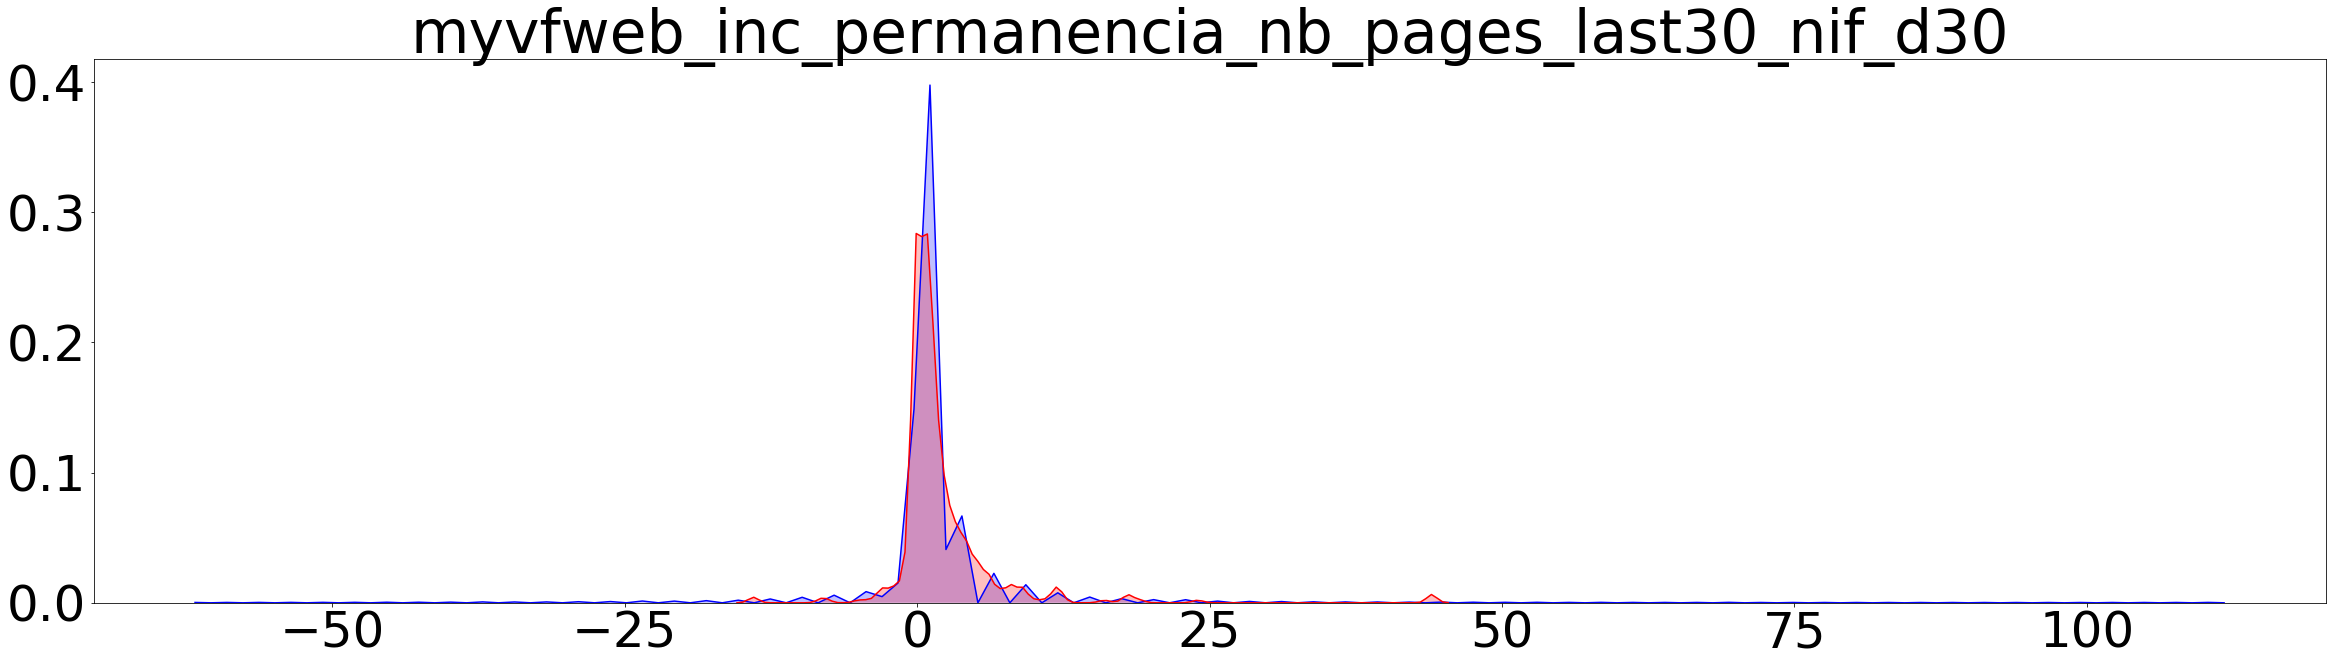

myvfweb_inc_apppostpago_nb_pages_last7_nif_d30


<Figure size 432x288 with 0 Axes>

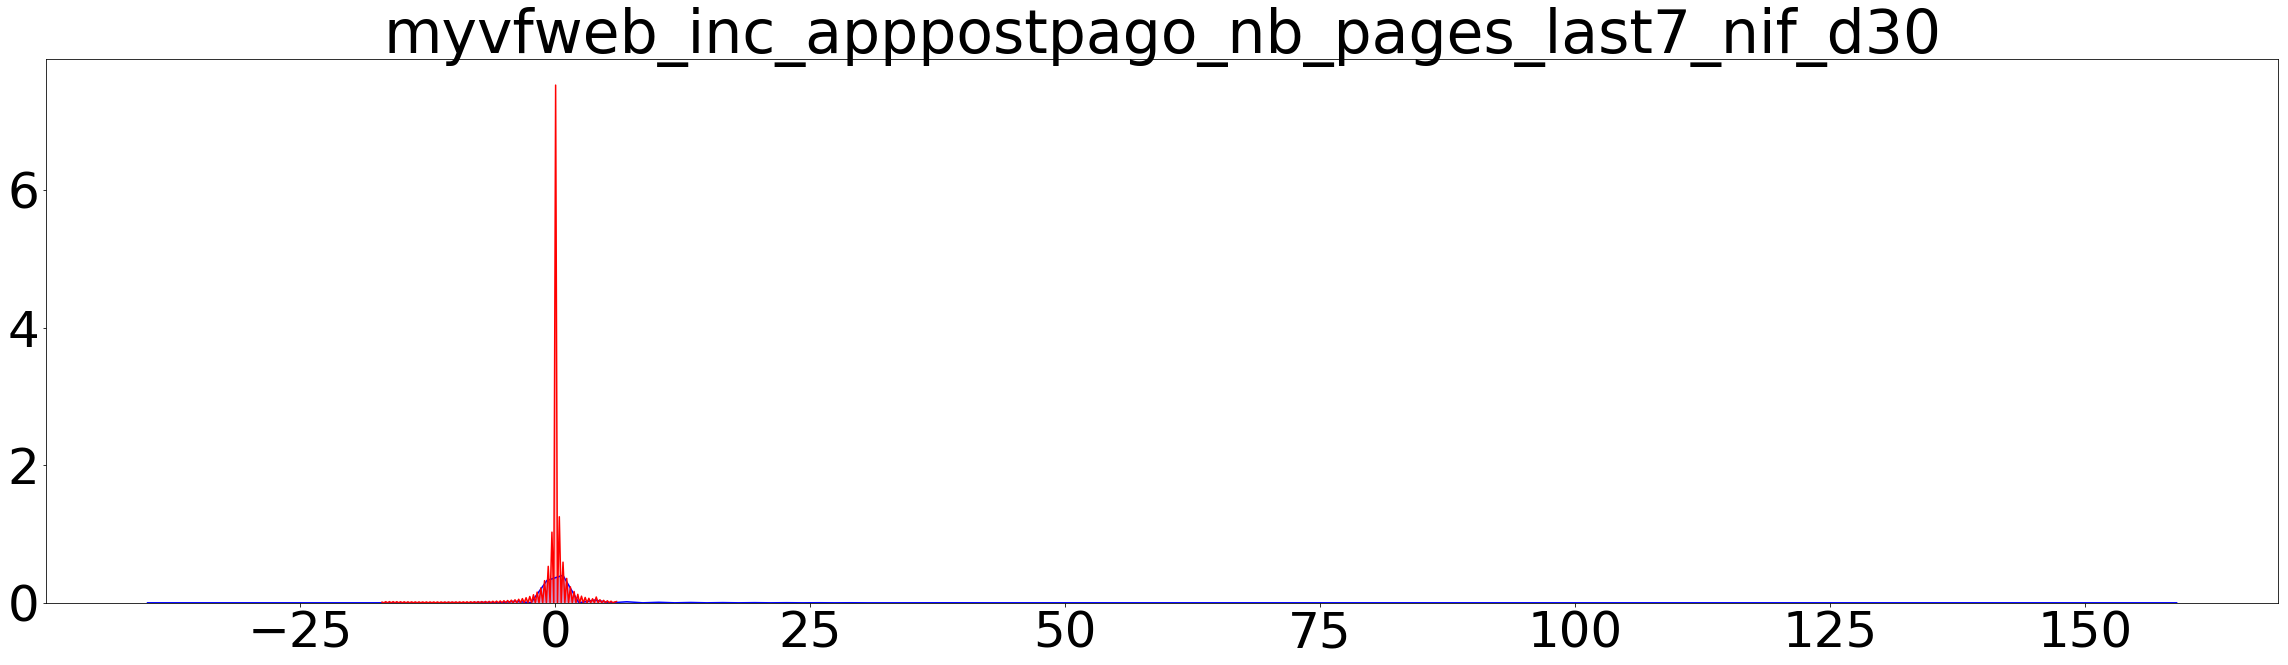

myvfweb_mi_vodafone_nb_pages_last7


<Figure size 432x288 with 0 Axes>

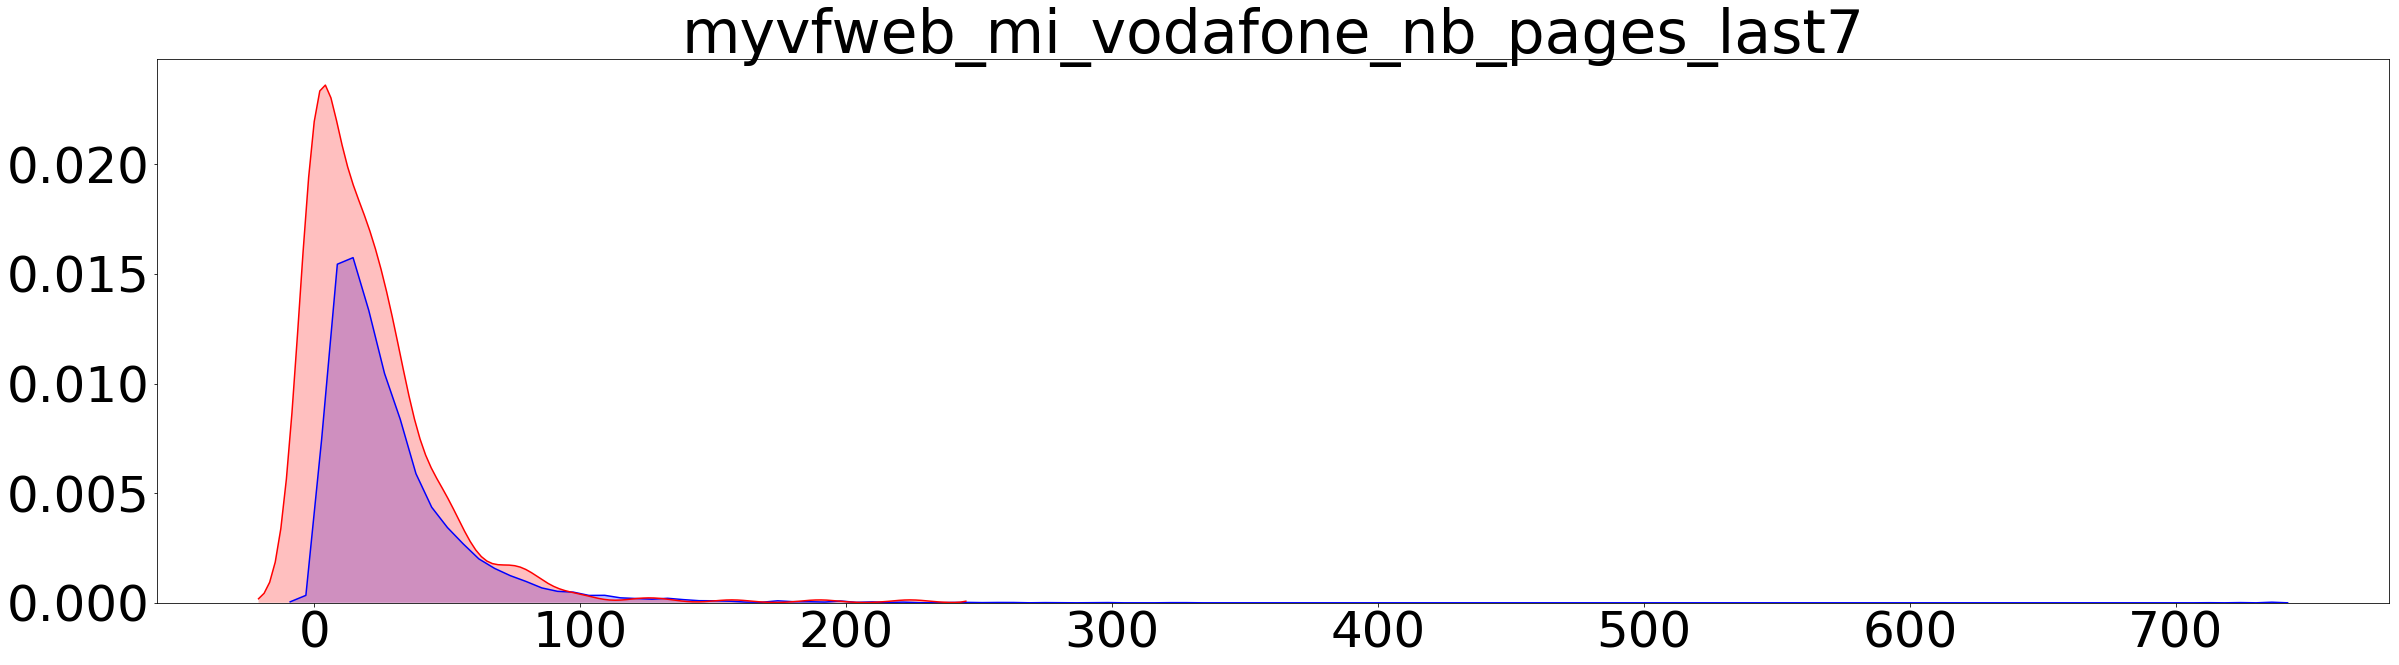

total_pepephone


<Figure size 432x288 with 0 Axes>

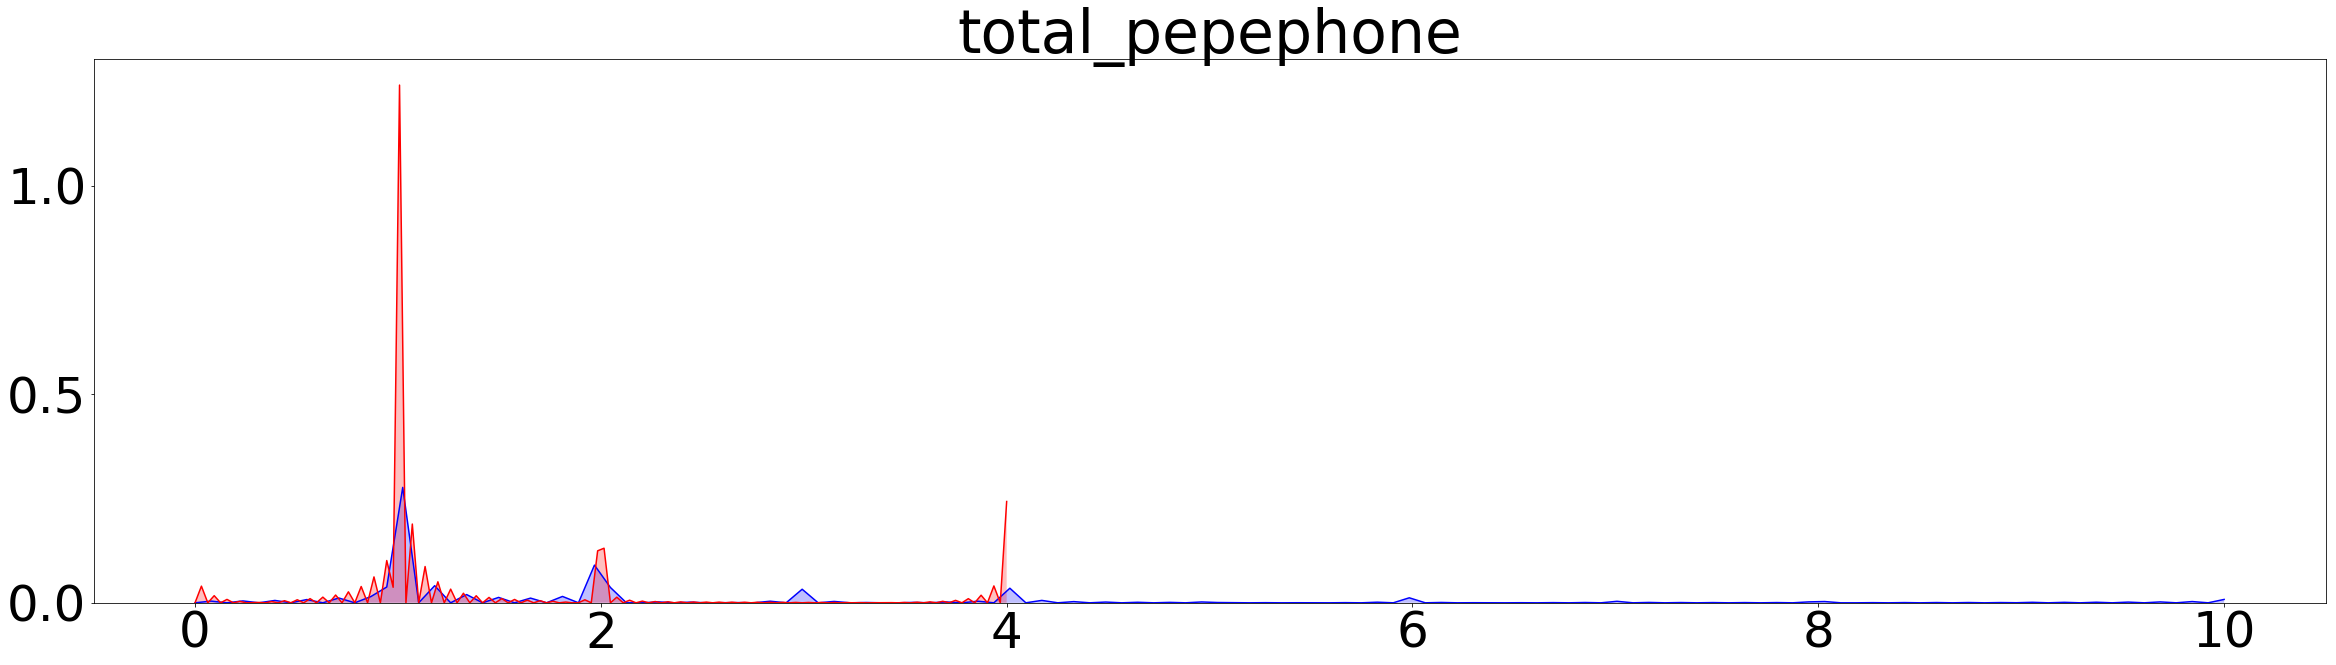

myvfweb_permanencia_nb_pages_last30


<Figure size 432x288 with 0 Axes>

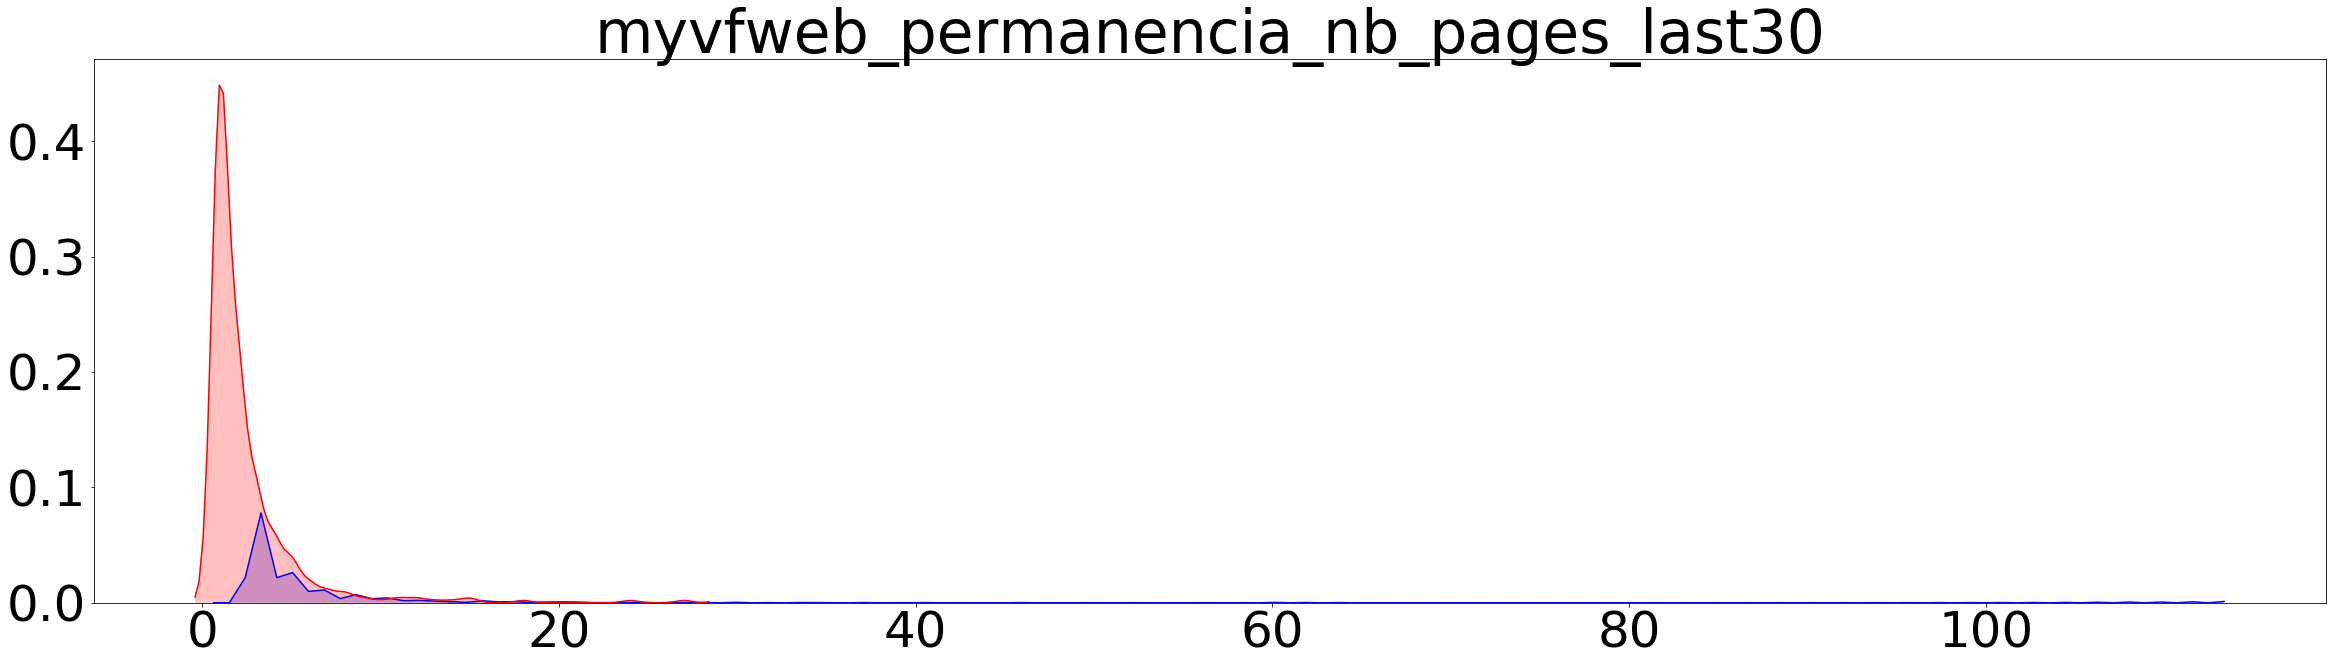

myvfweb_porsertu_nb_pages_last240


<Figure size 432x288 with 0 Axes>

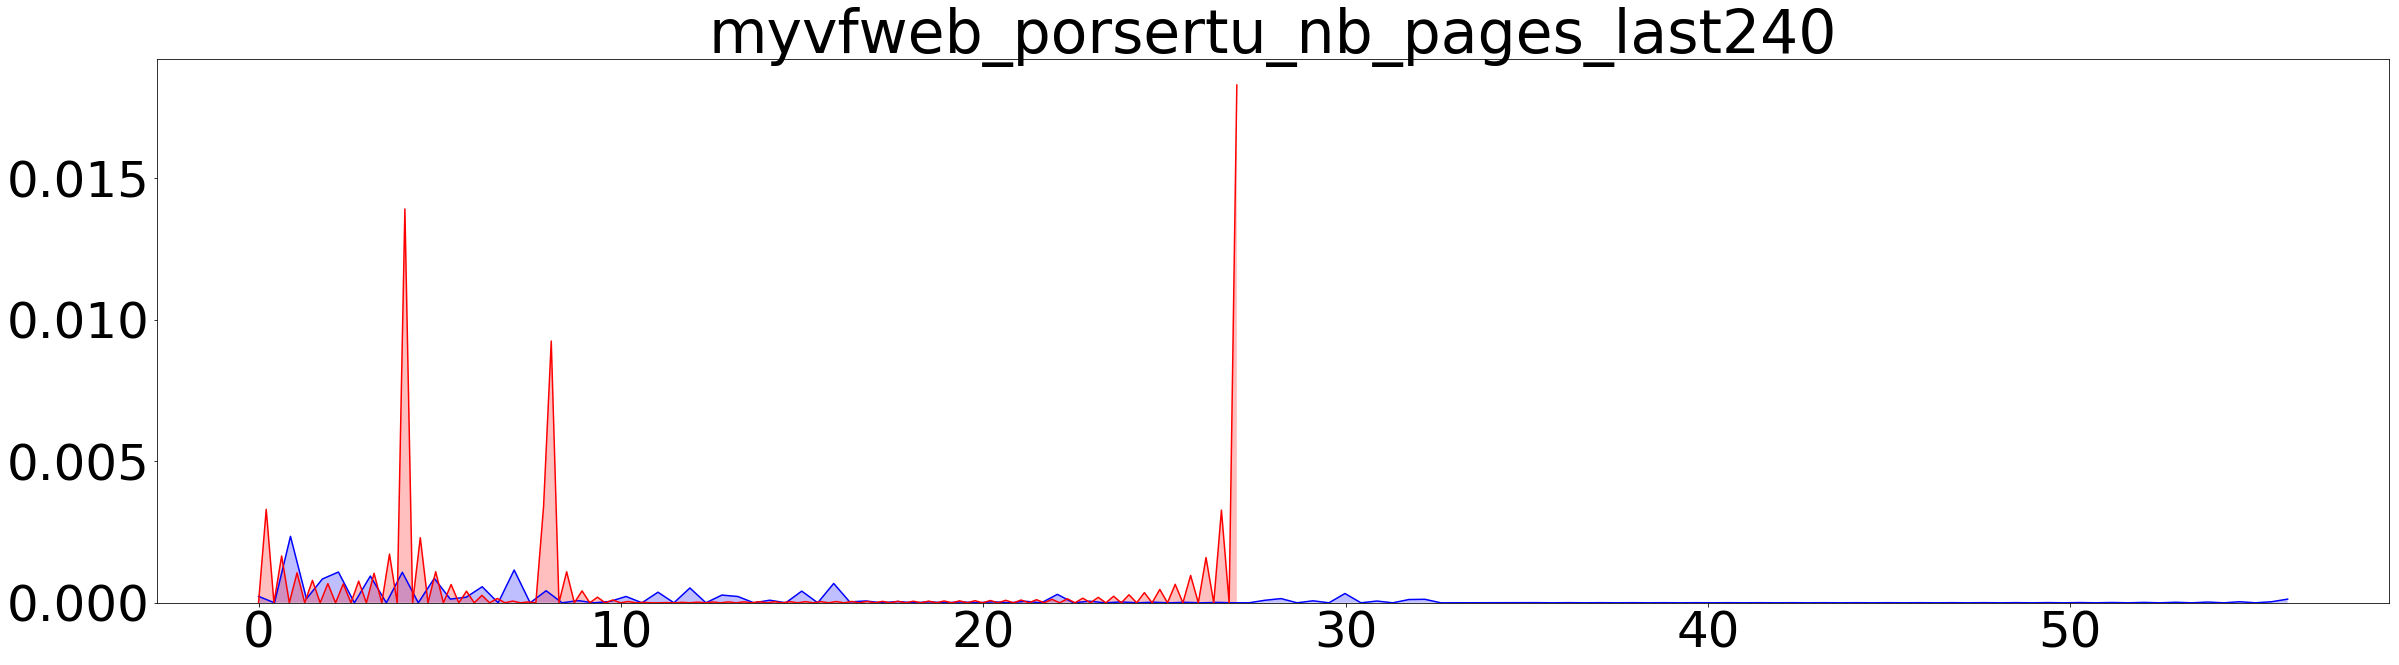

myvfweb_particulares_nb_pages_last14_nif_d60


<Figure size 432x288 with 0 Axes>

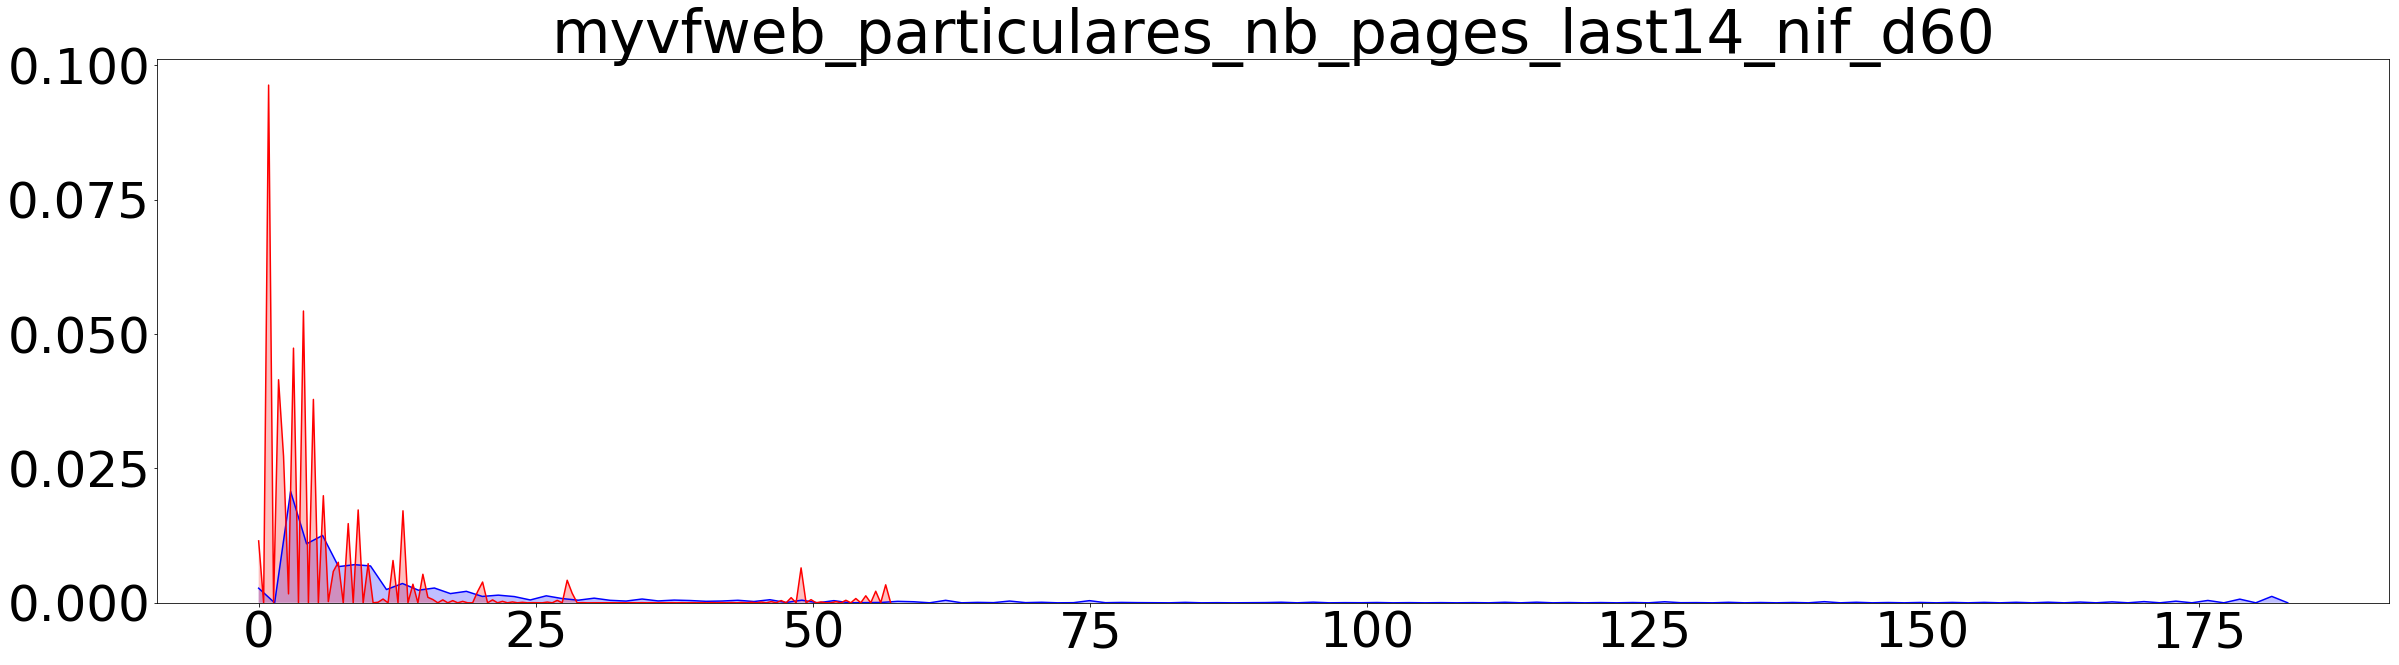

myvfweb_inc_eforum_nb_pages_last120_nif_d60


<Figure size 432x288 with 0 Axes>

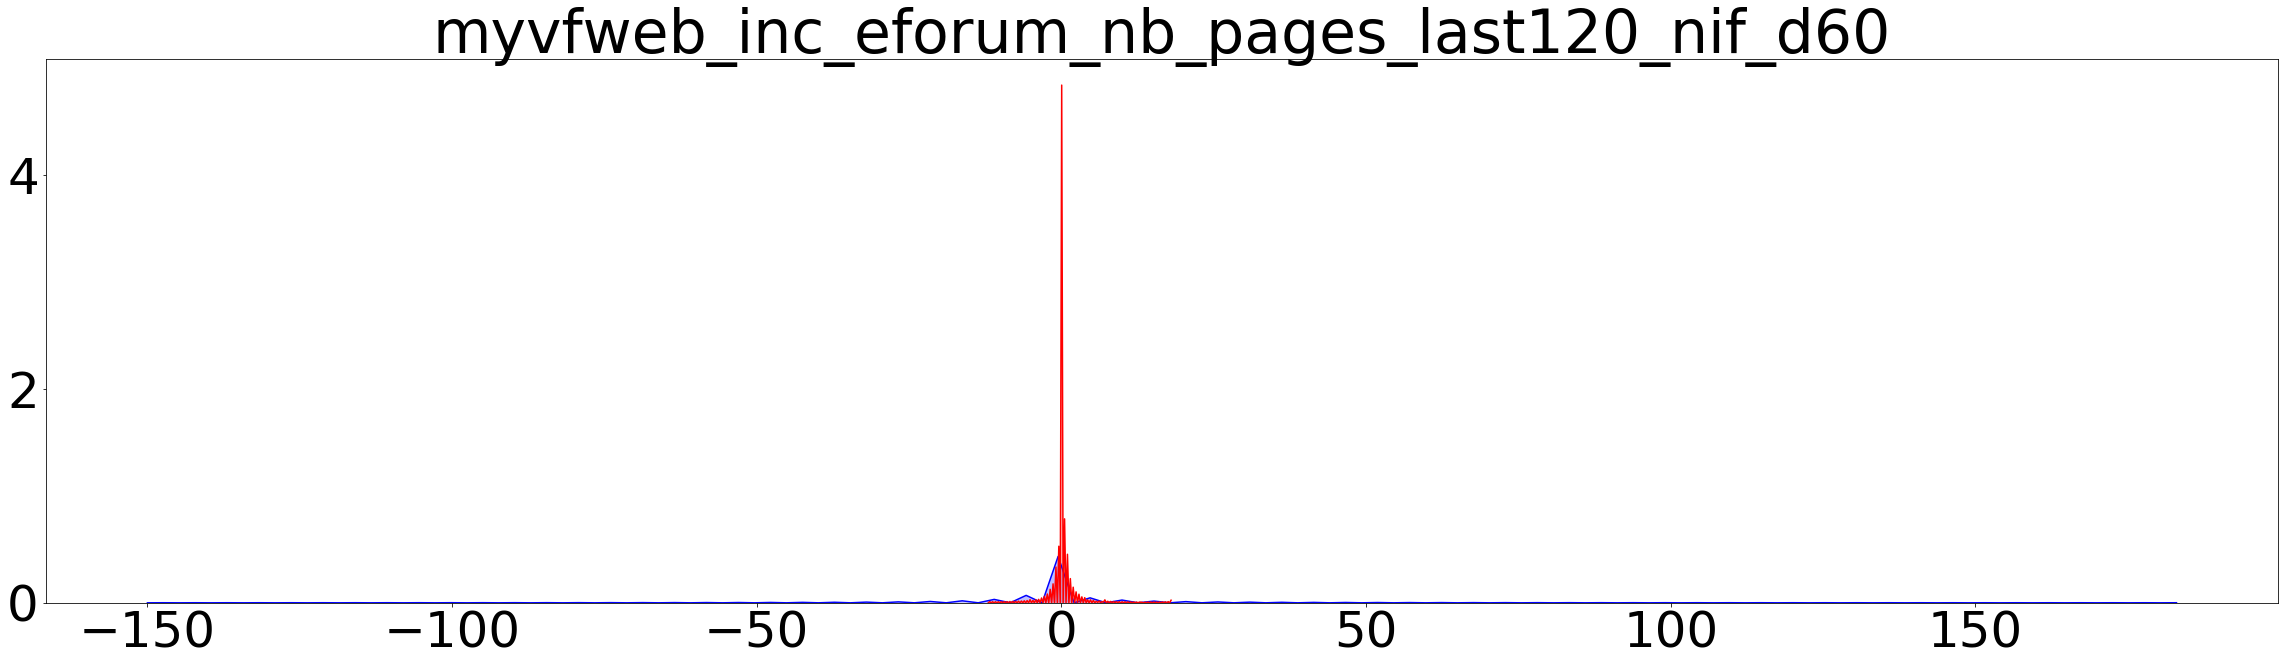

myvfweb_eforum_last_navig_last365_nif


<Figure size 432x288 with 0 Axes>

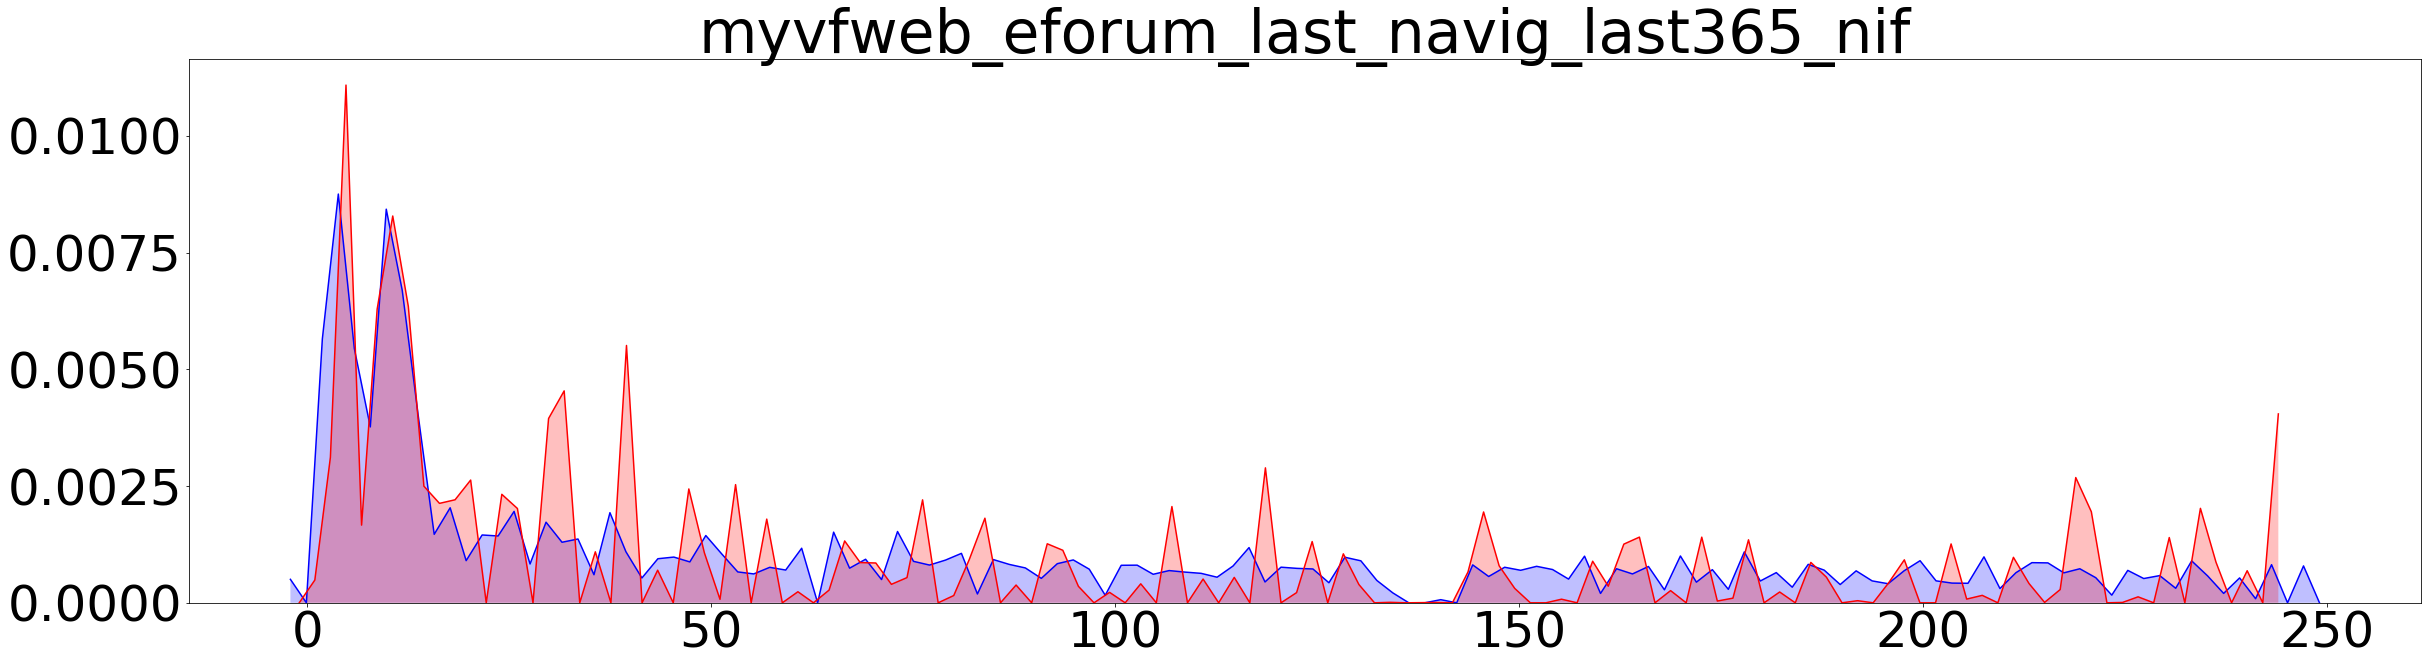

myvfweb_area_clientes_last_navig_last14


<Figure size 432x288 with 0 Axes>

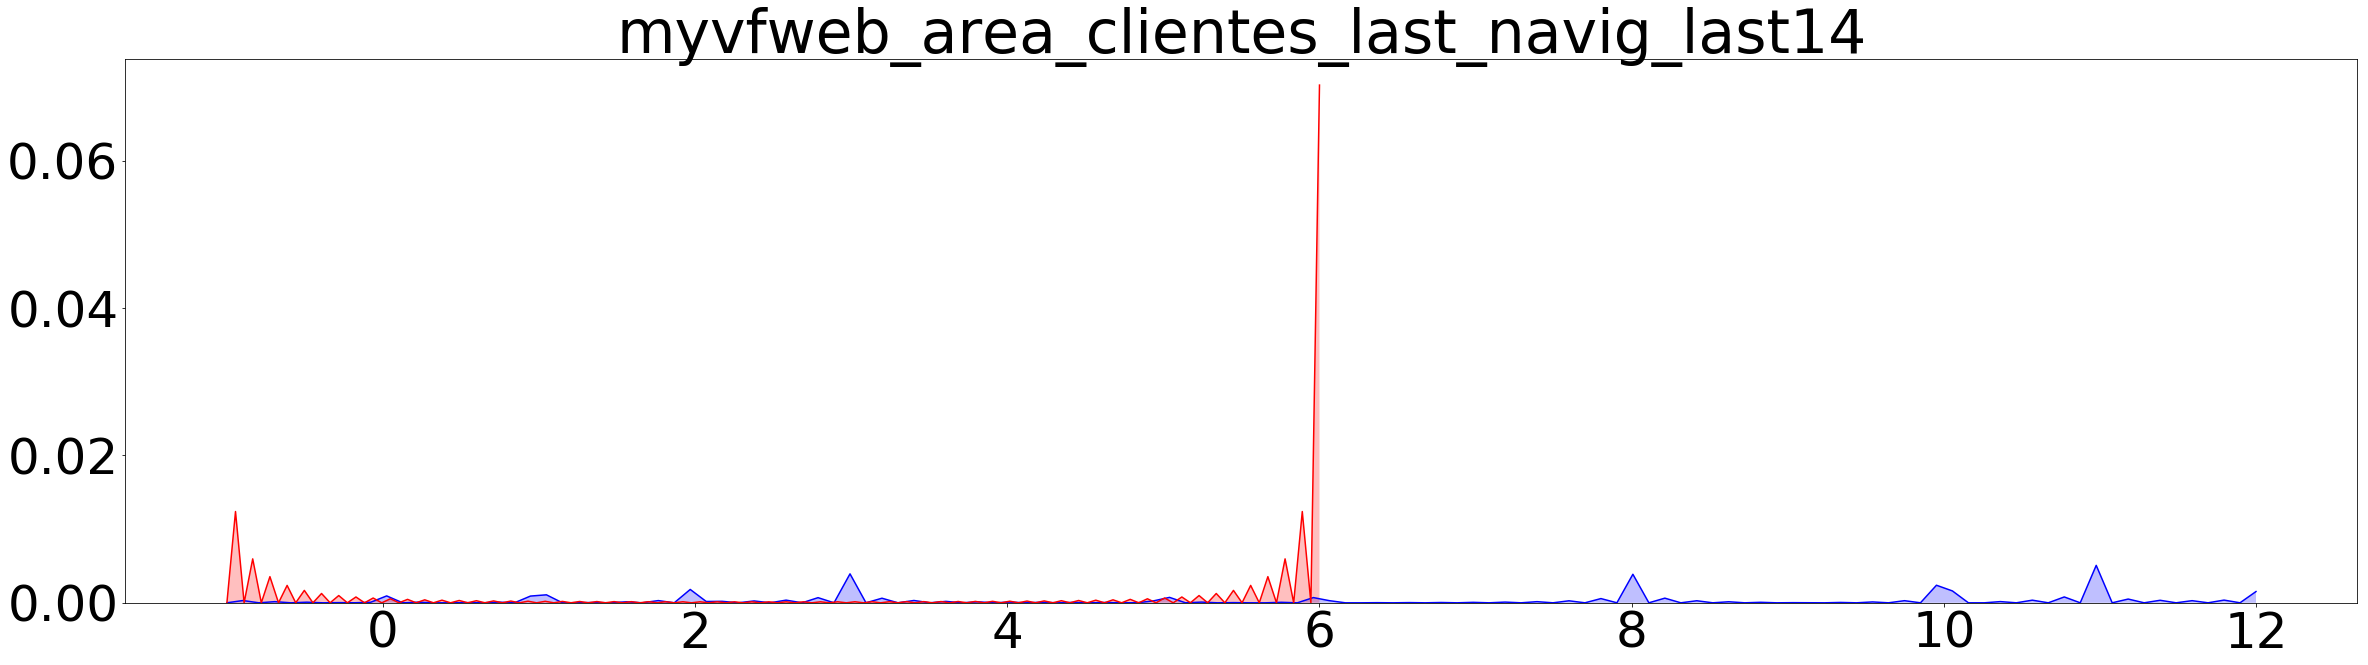

myvfweb_mi_vodafone_1st_navig_last365_nif


<Figure size 432x288 with 0 Axes>

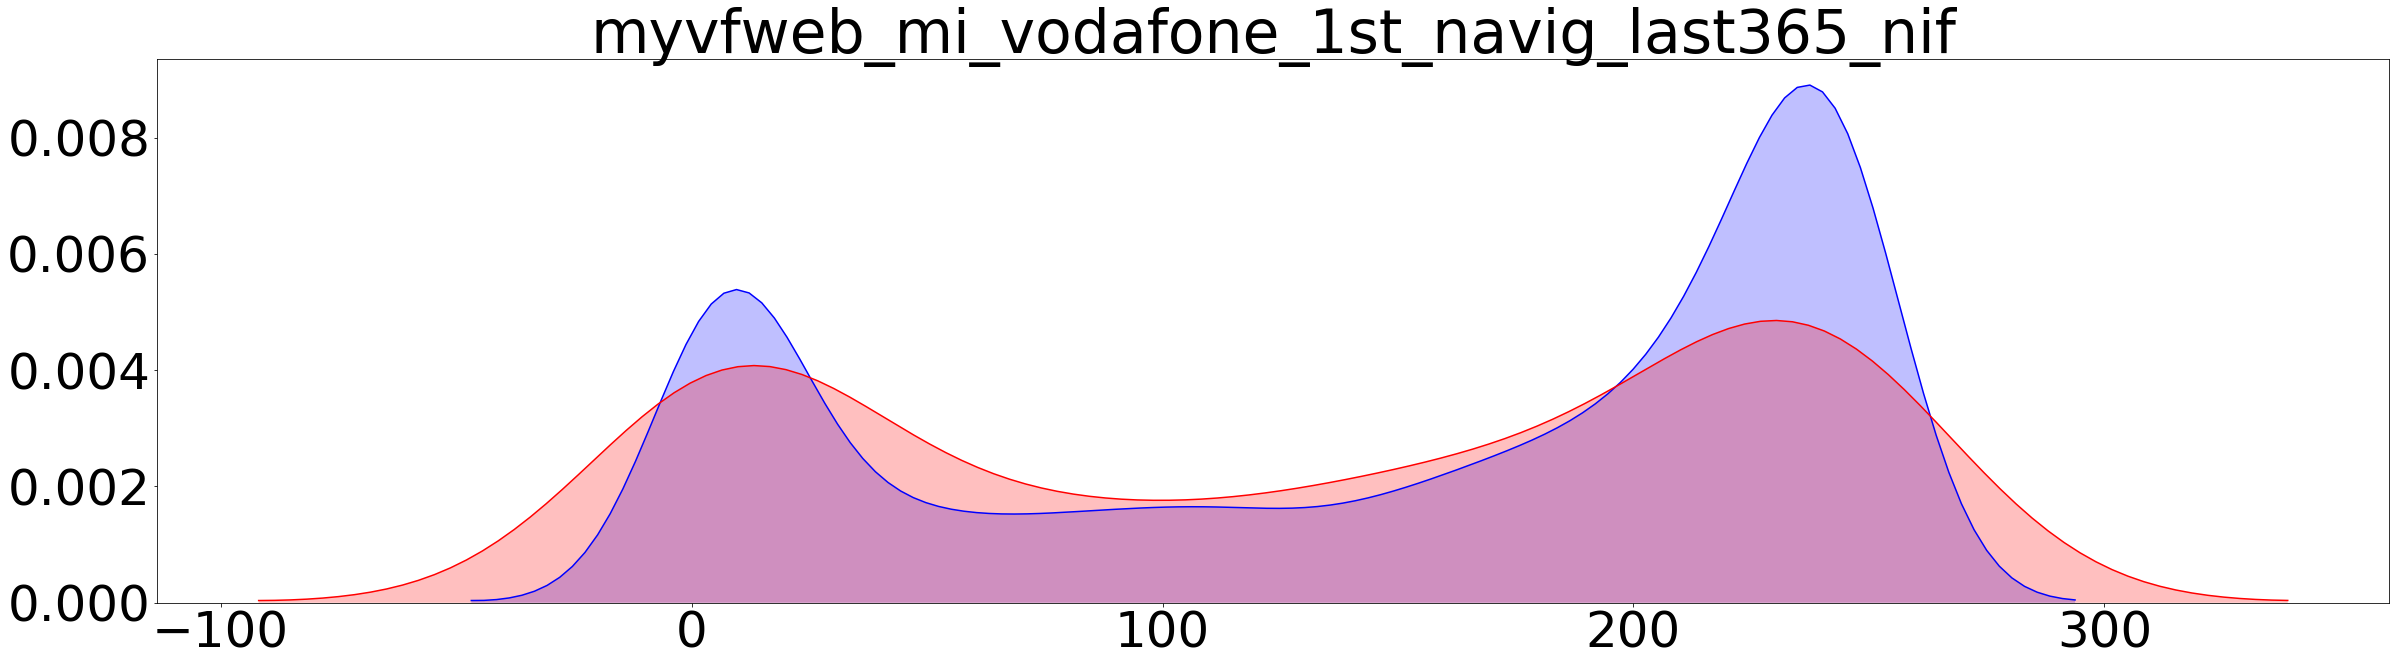

age


<Figure size 432x288 with 0 Axes>

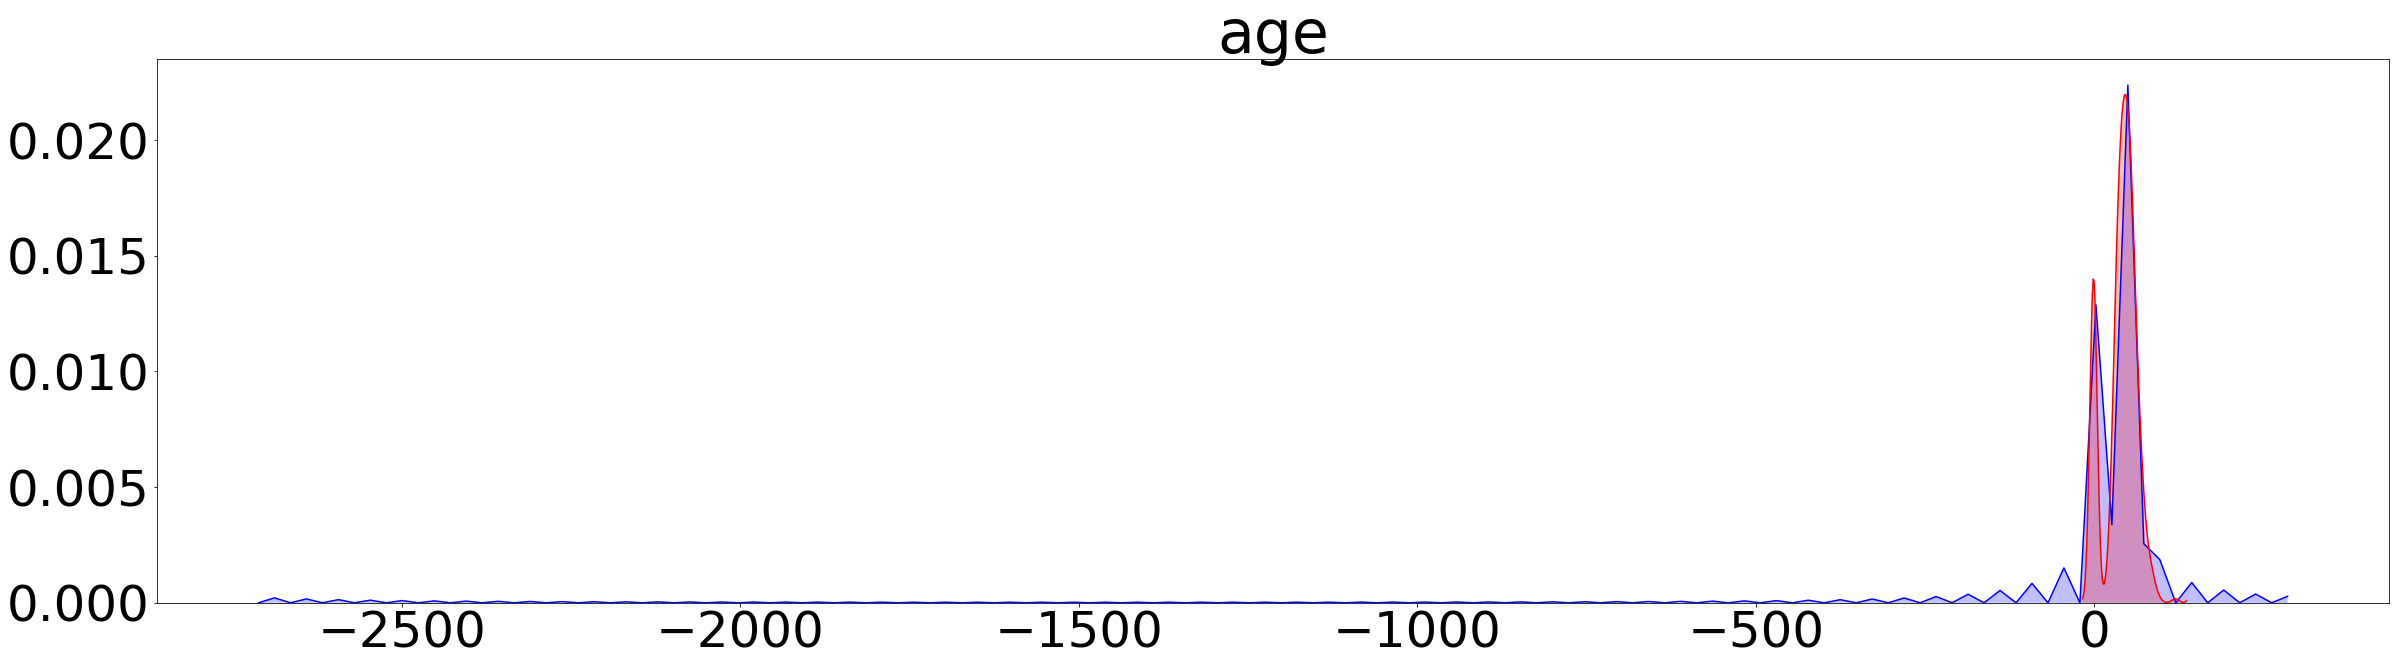

myvfweb_particulares_last_navig_last60


<Figure size 432x288 with 0 Axes>

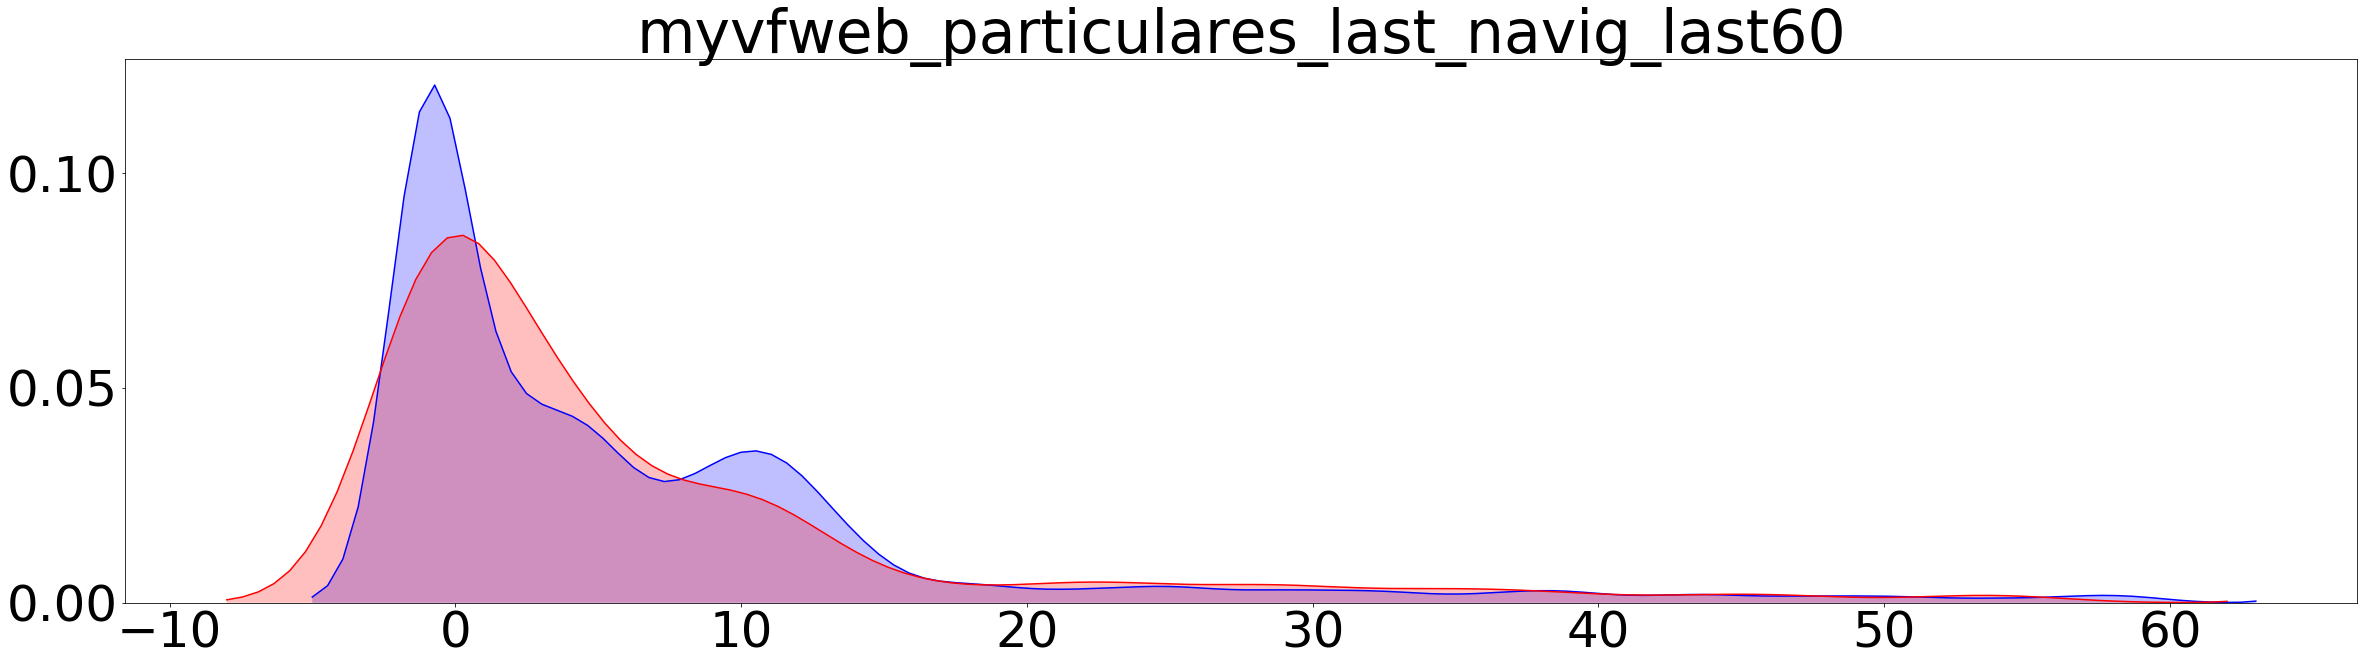

myvfweb_particulares_last_navig_last30_nif


<Figure size 432x288 with 0 Axes>

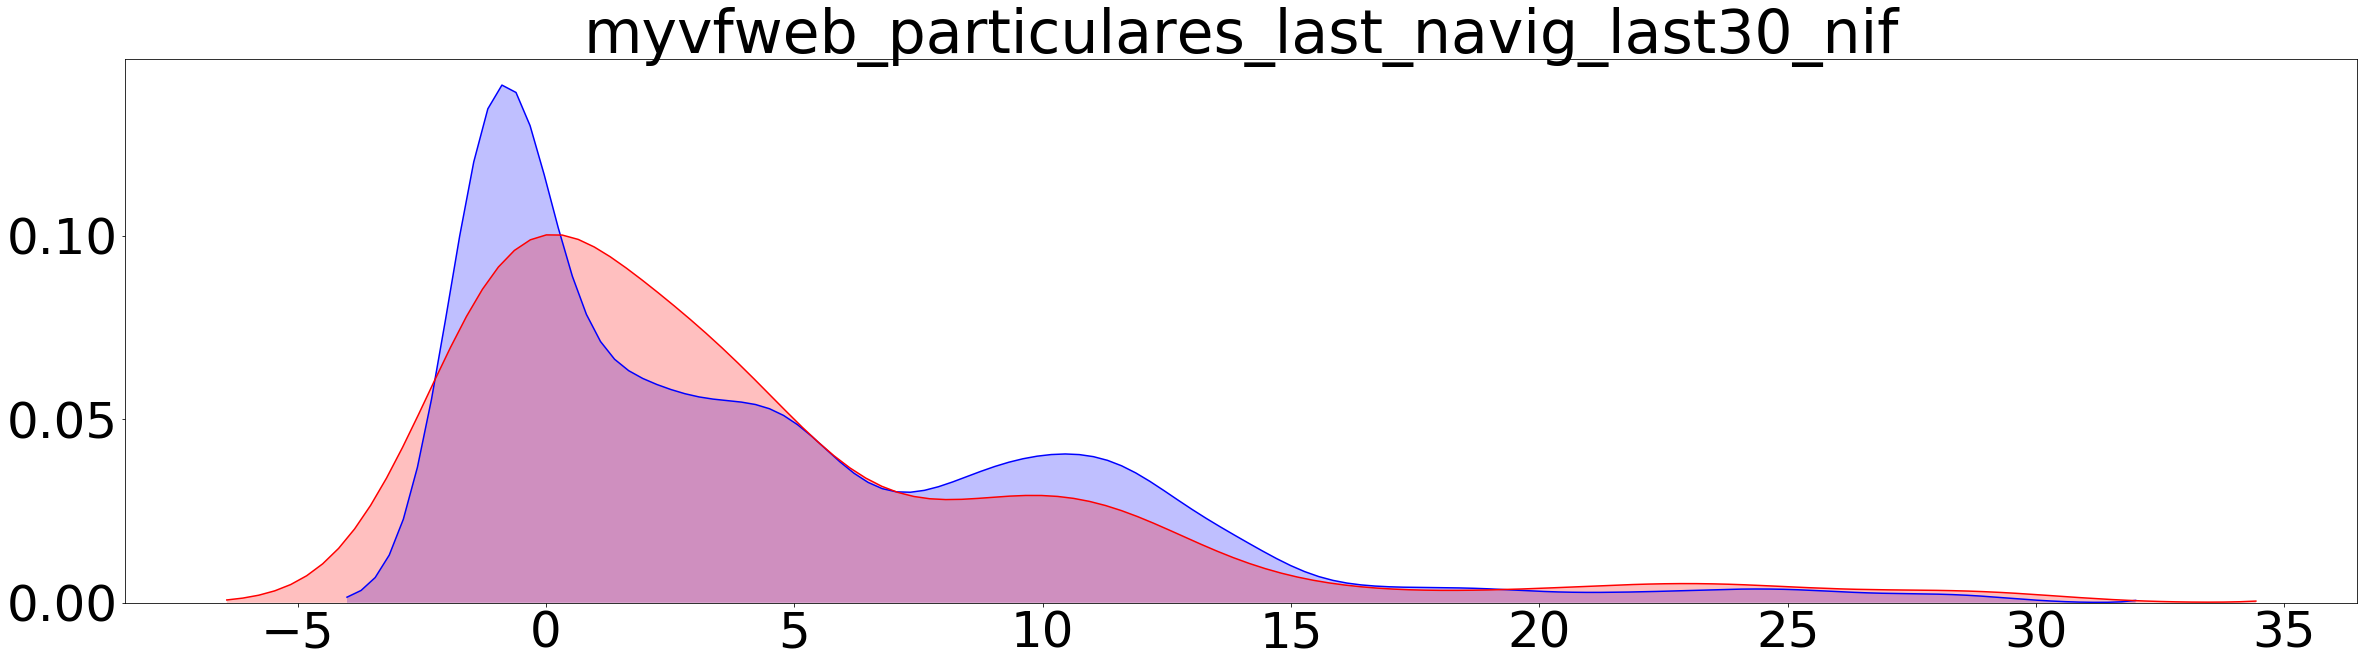

myvfweb_autonomos_last_navig_last365


<Figure size 432x288 with 0 Axes>

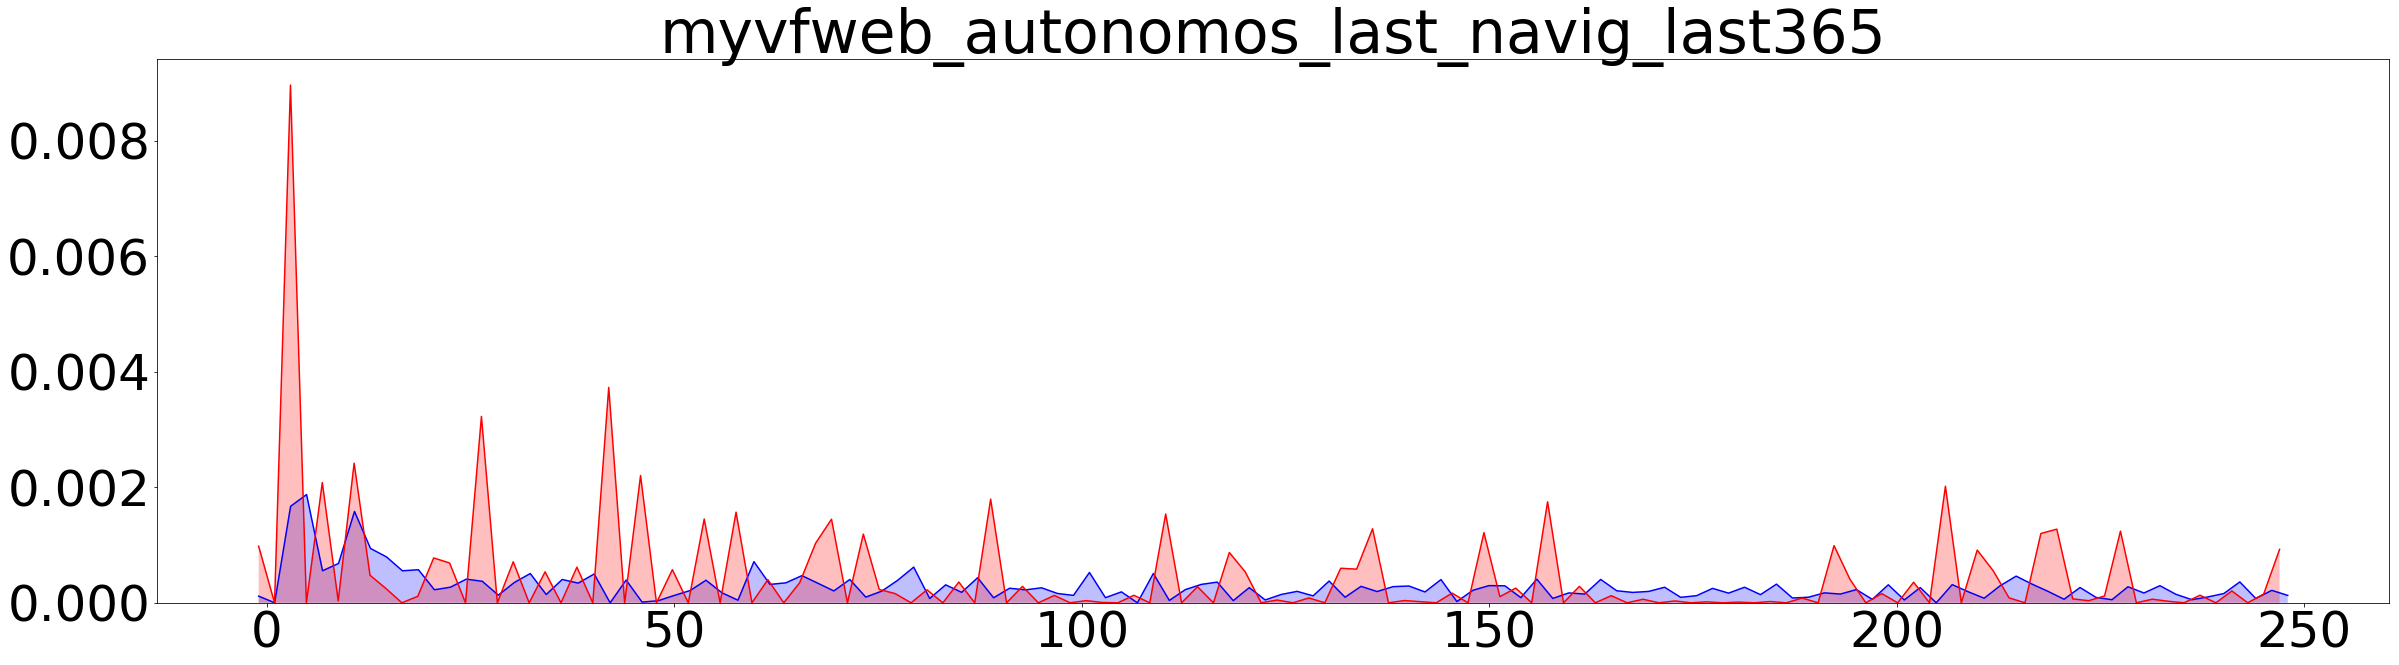

myvfweb_autonomos_nb_pages_last7


<Figure size 432x288 with 0 Axes>

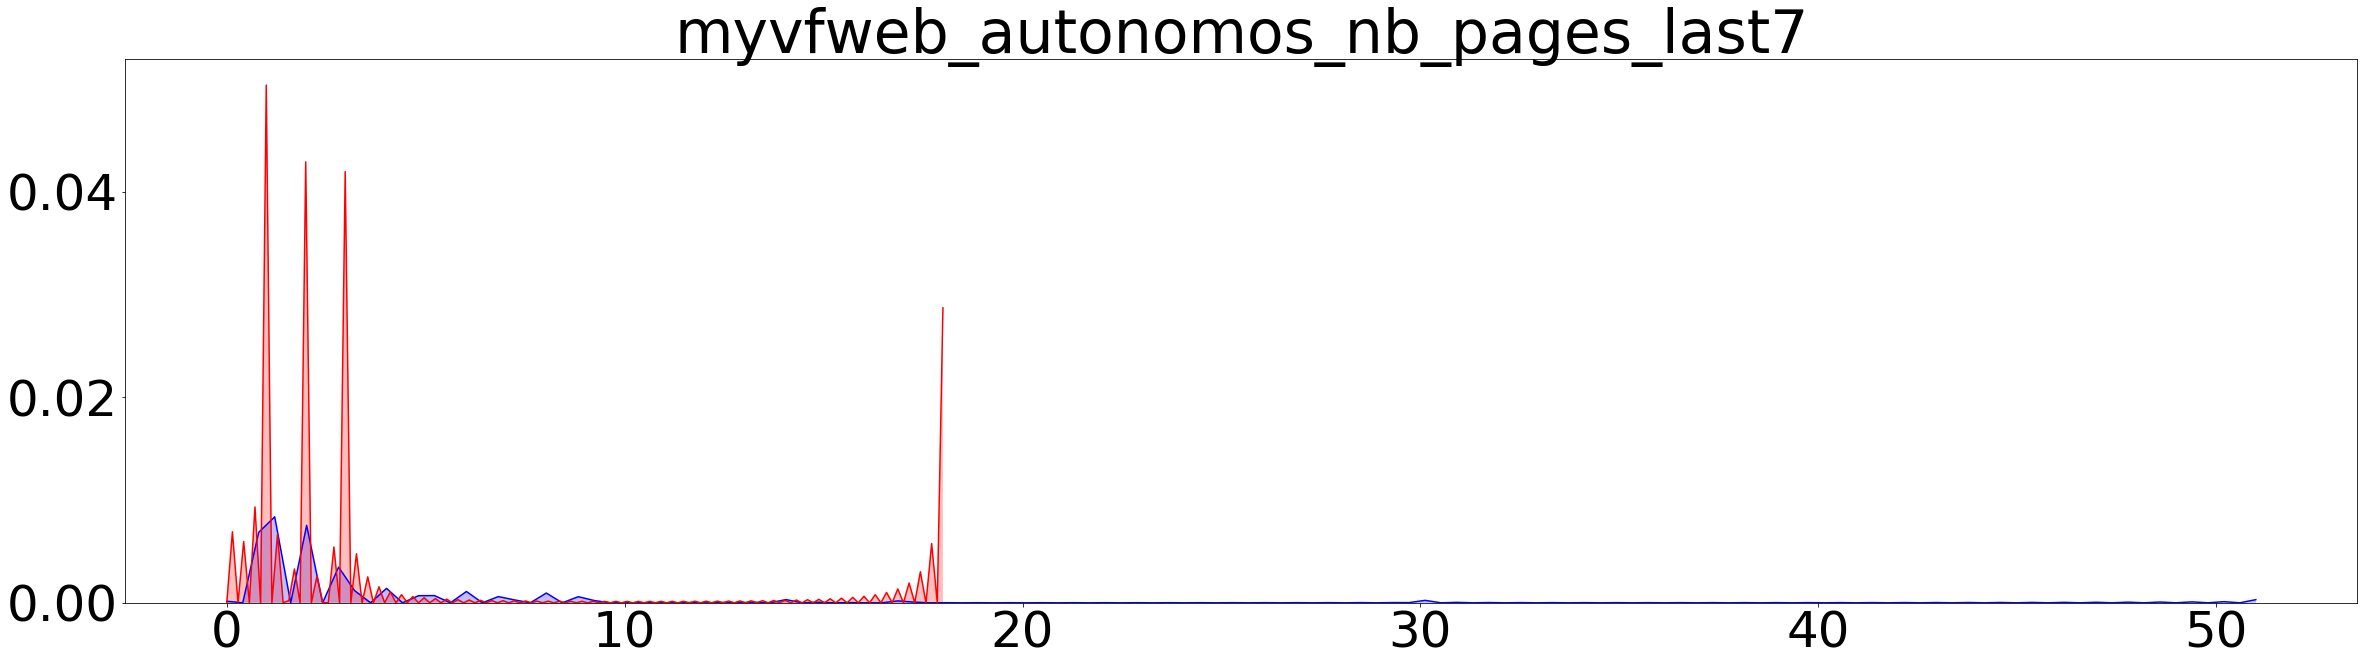

myvfweb_url_mivodafone_area_privada_contrato_last_navig_last365_nif


<Figure size 432x288 with 0 Axes>

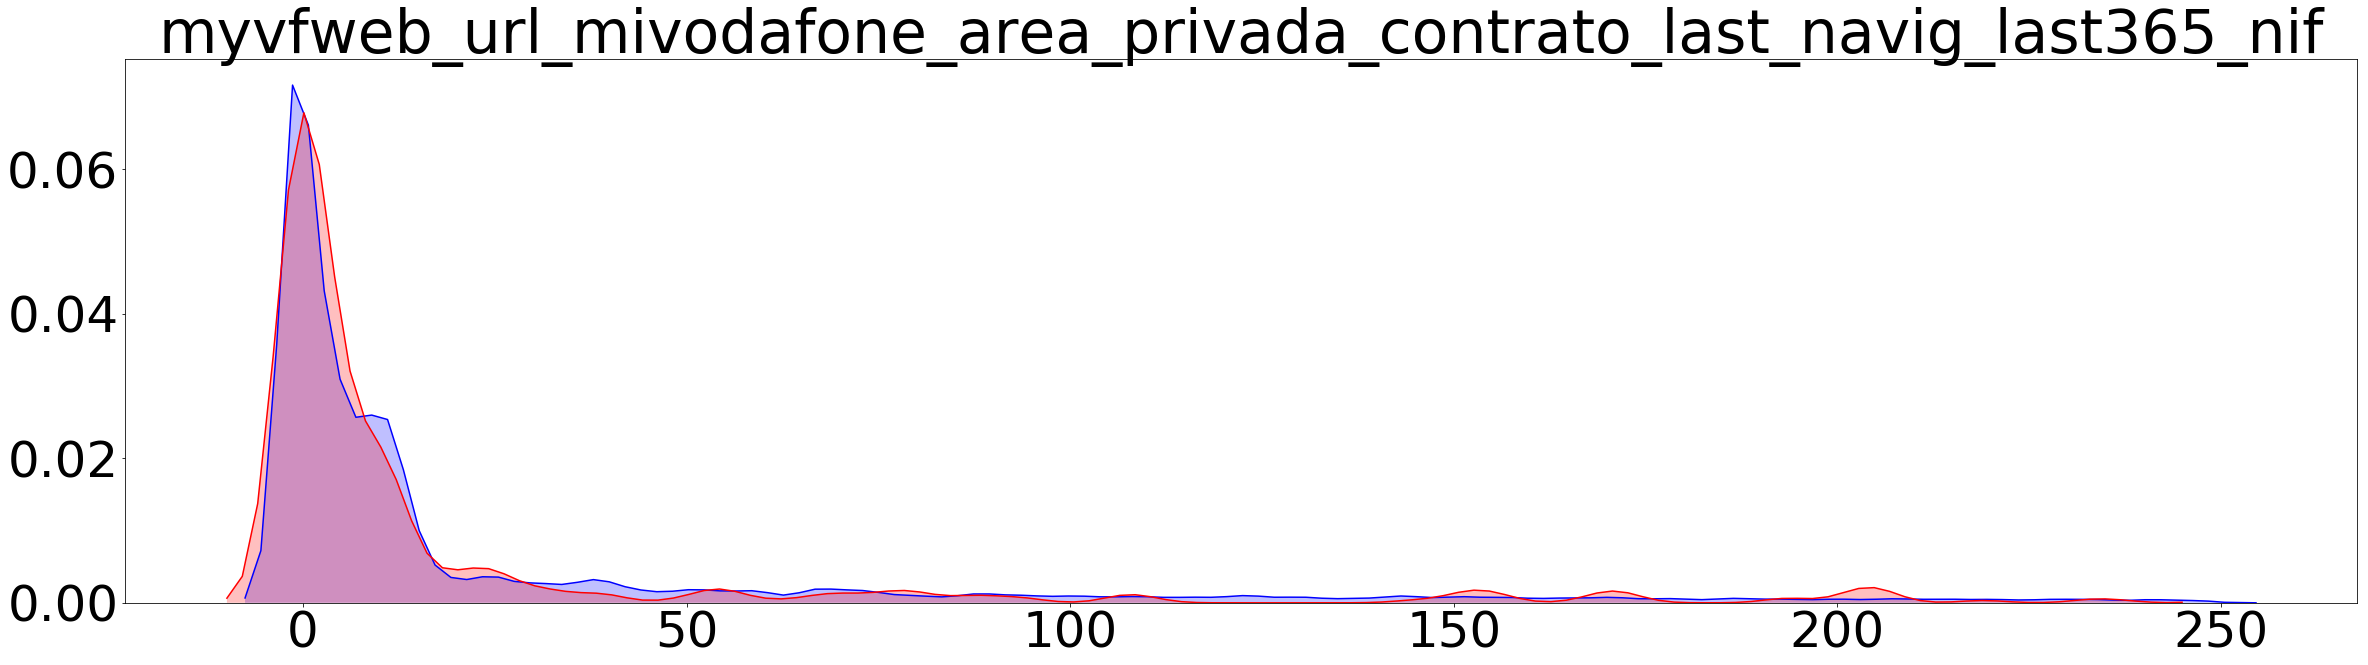

myvfweb_appautorizado_last_navig_last90_nif


<Figure size 432x288 with 0 Axes>

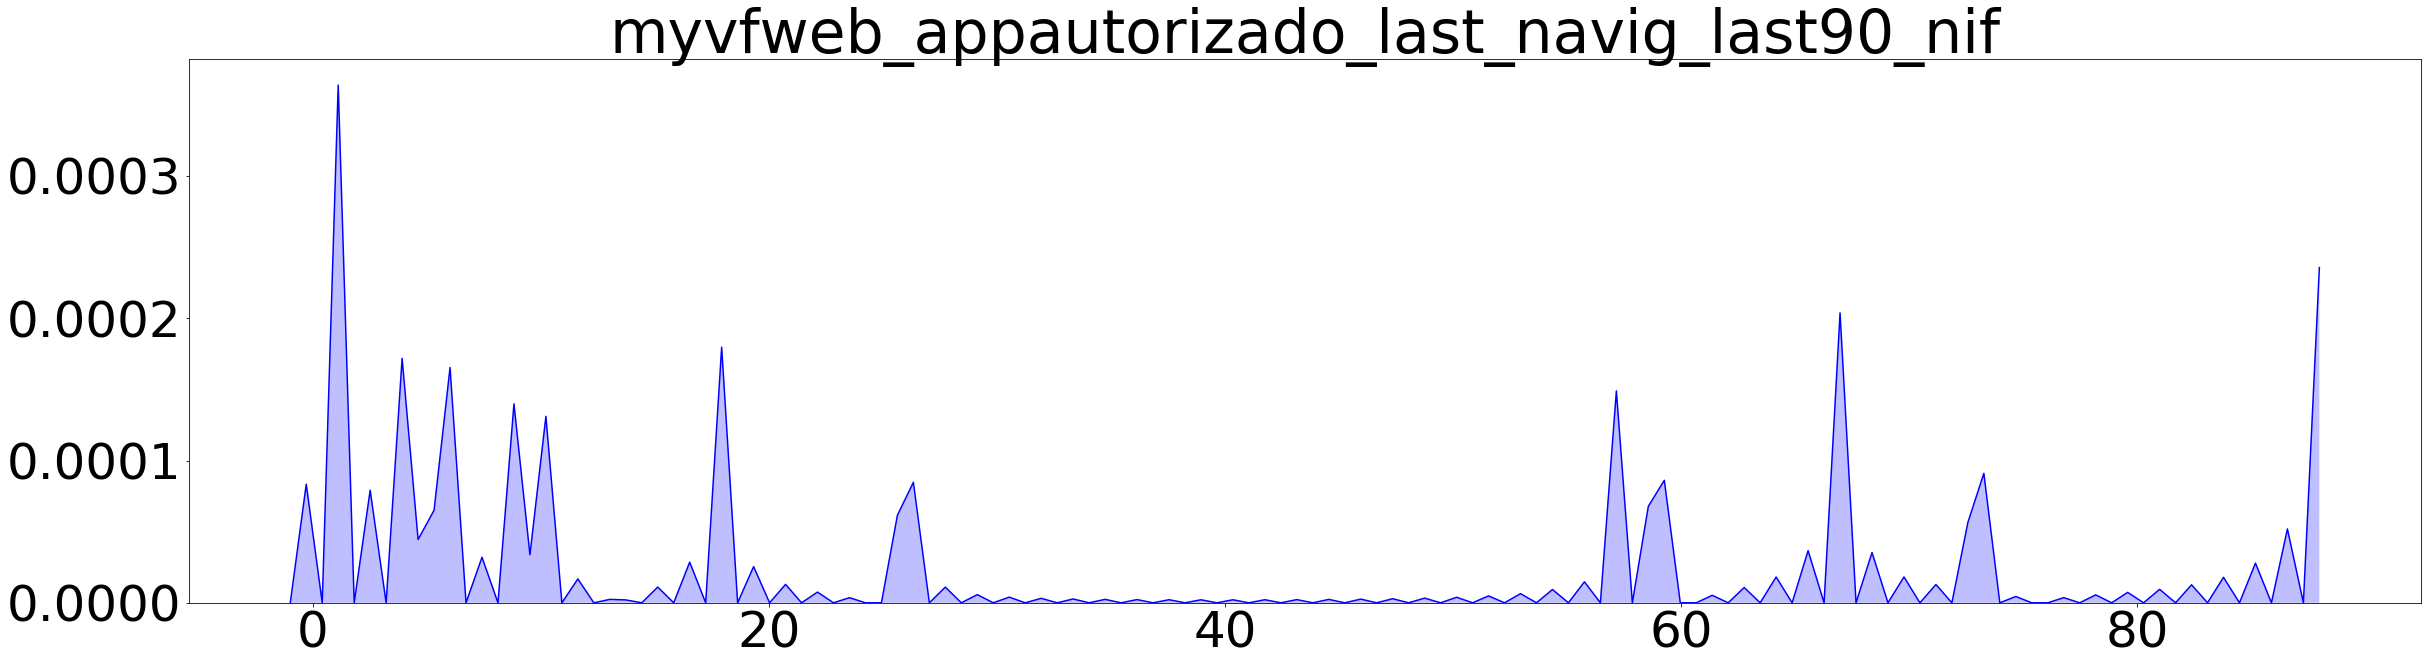

myvfweb_inc_eforum_nb_pages_last120_nif_d90


<Figure size 432x288 with 0 Axes>

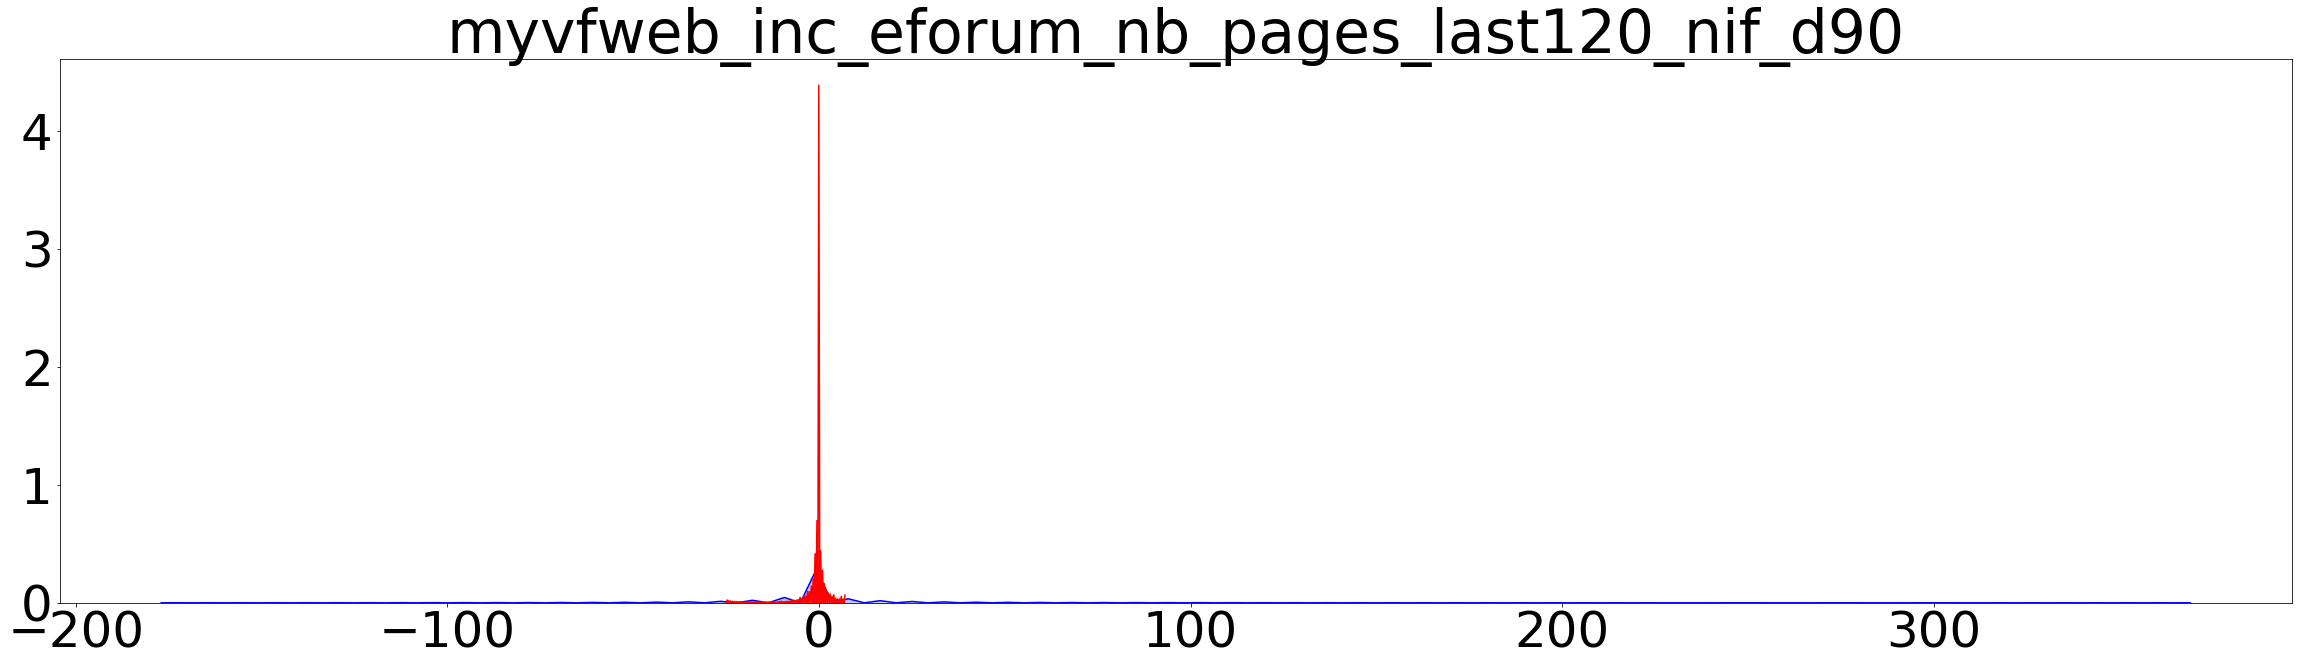

myvfweb_url_mivodafone_area_privada_contrato_nb_pages_last14_nif_d90


<Figure size 432x288 with 0 Axes>

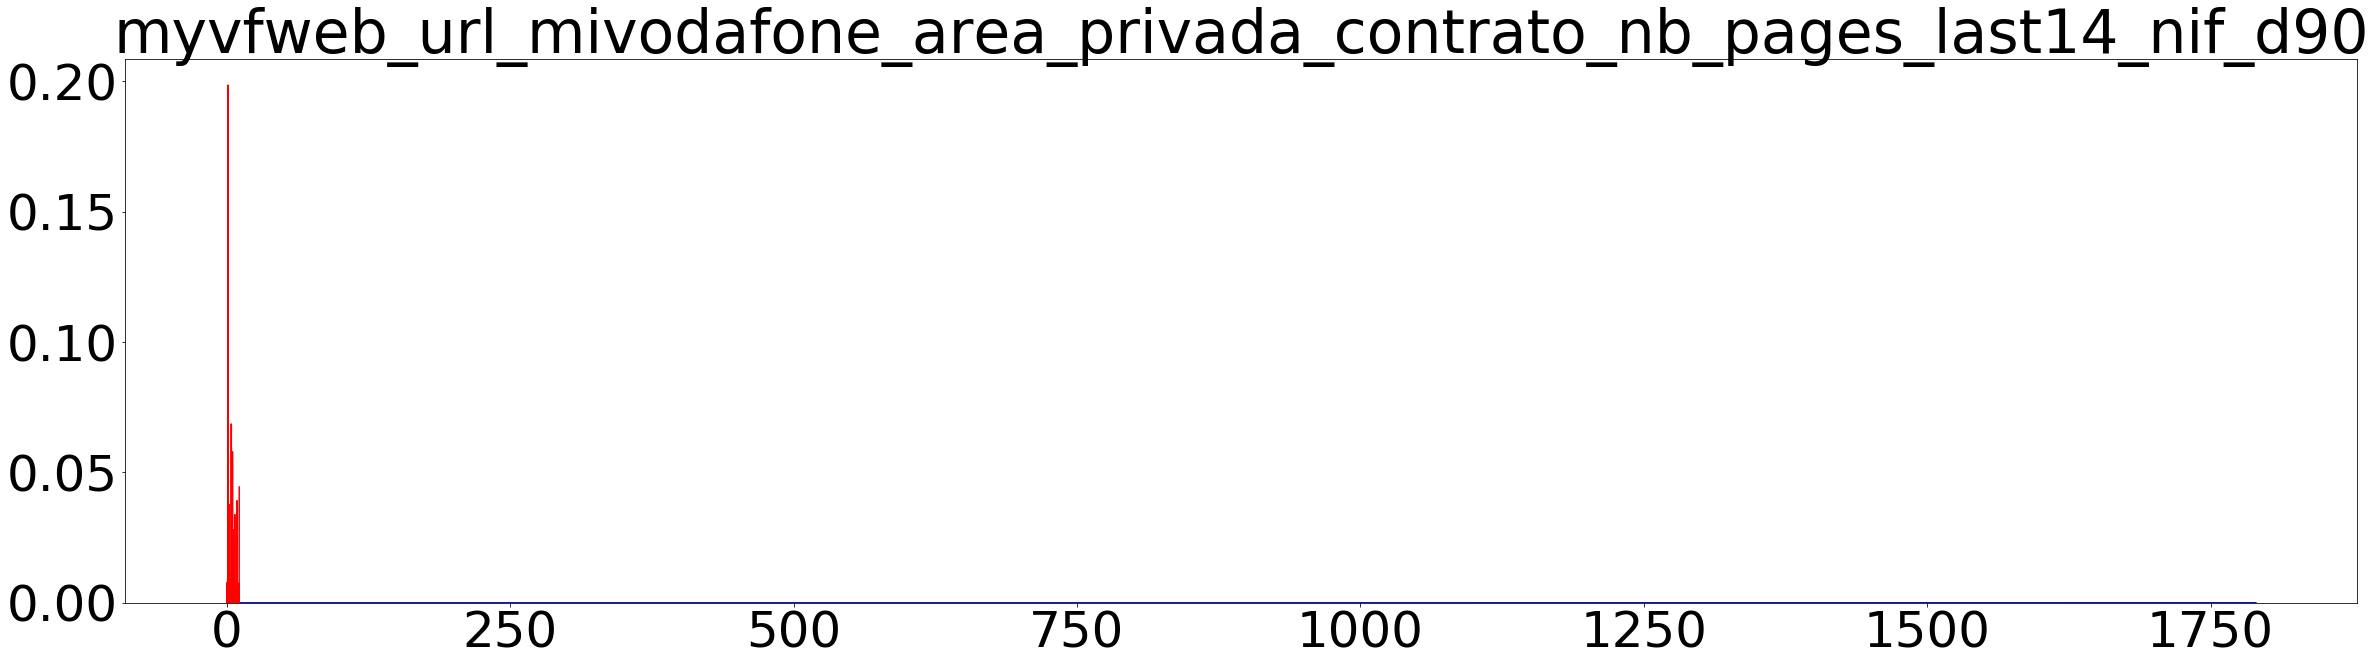

myvfweb_particulares_last_navig_last60_nif


<Figure size 432x288 with 0 Axes>

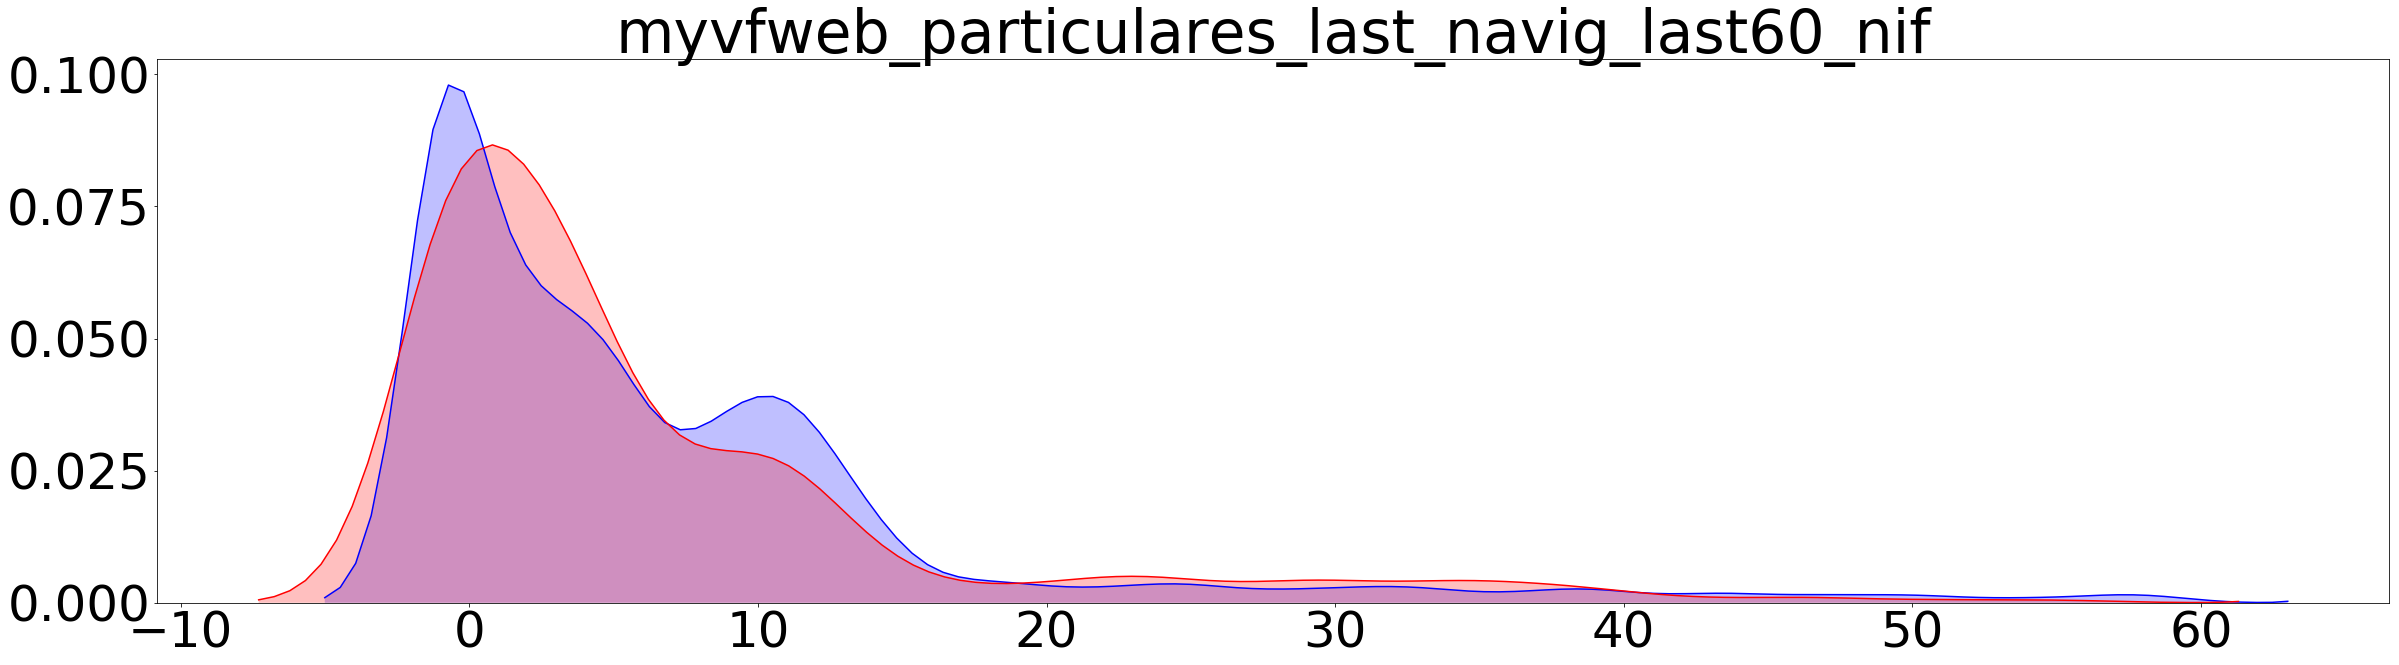

In [32]:
import numpy as np
import seaborn as sns
def plot_features_churn_seaborn_shade2(df, var_to_plot, label,  image_per_row = 3, hist = False):
    plt.rcParams["font.size"] = "50"
    plt.figure()
    inf = df.where(col(label) == 0)
    sup = df.where(col(label) == 1)
    inf.cache()
    sup.cache()
    fig_cat, axes = plt.subplots(int(np.ceil(len(var_to_plot)/ image_per_row)), image_per_row, figsize=(40, 10*int(np.round(len(var_to_plot)/ image_per_row))), squeeze=False)
    for i, ax in enumerate(fig_cat.axes):
        sel_ = var_to_plot[i]
        print(var_to_plot[i])

        arr = [float(row[sel_]) for row in inf.select(sel_).collect()]
        sns.kdeplot(arr, shade= True, color = 'blue', ax=axes[int(i/image_per_row)][i%image_per_row])
        arr2 = [float(row[sel_]) for row in sup.select(sel_).collect()]
        sns.kdeplot(arr2, shade= True, color = 'red', ax=axes[int(i/image_per_row)][i%image_per_row])
        
        axes[int(i/image_per_row)][i%image_per_row].set_title(sel_)
    inf.unpersist()
    sup.unpersist()
    #plt.rcParams["font.family"] = "Times New Roman"
    plt.show()

counter=1
for myvar in var_imp:
    
    if myvar in less_than_10values:
        counter += 1
        continue
    
    plot_features_churn_seaborn_shade2(df, var_to_plot=[myvar], label="label", image_per_row = 1, hist = False)


# Incrementals

In [8]:
from churn_nrt.src.utils.date_functions import days_range
from churn_nrt.src.utils.date_functions import move_date_n_days
from pyspark.sql.functions import avg as sql_avg
from churn_nrt.src.utils.date_functions import days_range


#label_kind = "mobile+fix"
label_kind = "mobile" 
CHURN_WINDOW = 15
step_days=1
verbose=True
compute_lift=True
top_ = 500

model_name = "myvf_app"
#model_name = "myvf_web"
#model_name = "triggers_navcomp"


range_dates = days_range("20200715", "20200730")
    

results_dict = {}
incrementals_top = {}
    
for closing_day in range_dates:
    
    closing_day_B = move_date_n_days(closing_day, n=step_days)
    print(" * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *")

        


    df_labels_A = spark.read.load("/data/attributes/vf_es/model_outputs/model_scores/model_name={}/year={}/month={}/day={}".format(model_name, closing_day[:4], int(closing_day[4:6]), int(closing_day[6:])))
    df_labels_B = spark.read.load("/data/attributes/vf_es/model_outputs/model_scores/model_name={}/year={}/month={}/day={}".format(model_name, closing_day_B[:4], int(closing_day_B[4:6]), int(closing_day_B[6:])))
    df_labels_join = df_labels_A.select("msisdn").join(df_labels_B.select("msisdn", "scoring"), ['msisdn'], 'right').where(df_labels_A['msisdn'].isNull())
    df_labels_join = df_labels_join.cache()
    vol_incremental = df_labels_join.count()
    if verbose: print("volumen incremental", vol_incremental)

    #print("NUM LABELS ORIG", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    if label_kind in  ["mobile+fix", "mobile"]:
        df_lab = get_label(spark, closing_day_B, kind=label_kind, churn_window=CHURN_WINDOW).select("msisdn", "label")
        df_labels_join = df_labels_join.drop("label")
        df_labels_join = df_labels_join.join(df_lab, on=["msisdn"], how="left").na.fill({'label': 0.0})
        
    elif label_kind != "mobile":
        print("Unknown kind {}. Program will exit here!".format(label_kind))
        import sys
        sys.exit()

    #print("NUM LABELS AFTER", df_labels_join.select(sql_sum('label').alias('num_churners')).rdd.first()['num_churners'])

    churn_rate_all_incremental = df_labels_join.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
    print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(vol_incremental), churn_rate_all_incremental * 100)
    
    myschema3 = df_labels_join.schema
    
    
    if top_ and top_ < vol_incremental:
        from pyspark.sql.functions import avg as sql_avg
        df_labels_join = df_labels_join.sort(desc("scoring"))
        df_top = spark.createDataFrame(df_labels_join.head(top_), schema=myschema3)
        tt_churn_rate = df_top.select(sql_avg('label').alias('churn_ref')).rdd.first()['churn_ref']
        incrementals_top[top_] = tt_churn_rate * 100
        
        
        print("------", label_kind, closing_day, closing_day_B, "ChRate{}".format(top_), tt_churn_rate * 100)
        
        if compute_lift:
            from churn_nrt.src.projects_utils.models.modeler import get_cumulative_churn_rate_fix_step
            cum_churn_rate = get_cumulative_churn_rate_fix_step(spark, df_labels_join, ord_col =  'scoring', label_col = 'label', step_=top_)
        
            
        results_dict[closing_day] = cum_churn_rate


 * - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - *
('volumen incremental', 5844)
[DataTemplate] __init__ | module name = mob_port/15 | path = /data/udf/vf_es/churn_nrt/mob_port/15 | verbose = True
[DataTemplate] get_module | module mob_port/15 - for closing_day=20200716 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/mob_port/15/year=2020/month=7/day=16'
('------', 'mobile', '20200715', '20200716', 'ChRate5844', 3.3196440793976727)
('------', 'mobile', '20200715', '20200716', 'ChRate500', 10.6)
[modeler] get_cumulative_lift_fix_step | Size of the input df: 5844
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 500: 11 - Final number of buckets: 11
+------+------+------------+----------------+----------+--------------------+--------------------+------------+------------

('volumen incremental', 6718)
[DataTemplate] __init__ | module name = mob_port/15 | path = /data/udf/vf_es/churn_nrt/mob_port/15 | verbose = True
[DataTemplate] get_module | module mob_port/15 - for closing_day=20200719 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
[MobPort] check_valid_params | Params ok
[DataTemplate] get_module | Found already an existing module - '/data/udf/vf_es/churn_nrt/mob_port/15/year=2020/month=7/day=19'
('------', 'mobile', '20200718', '20200719', 'ChRate6718', 3.1557011015183085)
('------', 'mobile', '20200718', '20200719', 'ChRate500', 12.0)
[modeler] get_cumulative_lift_fix_step | Size of the input df: 6718
[modeler] get_cumulative_lift_fix_step |  Number of buckets for a resolution of 500: 13 - Final number of buckets: 13
+------+------+------------+----------------+----------+---------------------+--------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|nu

+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|bucket|volume|num_churners|cum_num_churners|cum_volume|churn_rate          |cum_churn_rate     |total_volume|total_churners|cum_captured_churn |cum_volume_for_capture|
+------+------+------------+----------------+----------+--------------------+-------------------+------------+--------------+-------------------+----------------------+
|7.0   |509   |90.0        |90.0            |509       |0.17681728880157171 |0.17681728880157171|4070        |234.0         |0.38461538461538464|0.12506142506142506   |
|6.0   |509   |42.0        |132.0           |1018      |0.0825147347740668  |0.12966601178781925|4070        |234.0         |0.5641025641025641 |0.2501228501228501    |
|5.0   |509   |38.0        |170.0           |1527      |0.07465618860510806 |0.11132940406024885|4070        |234.0         |0.7264957264957265 |0.37518427

('volumen incremental', 11259)
[DataTemplate] __init__ | module name = mob_port/15 | path = /data/udf/vf_es/churn_nrt/mob_port/15 | verbose = True
[DataTemplate] get_module | module mob_port/15 - for closing_day=20200725 save=False save_others=True force_gen=False
[DataTemplate] get_module | args: () | kwargs: {}
ERROR: closing_day [20200725] + churn_window [15] = 20200812. It must be lower than today [20200811] - 3 days.
ERROR: Program will exit here!


SystemExit: 

In [11]:
type(df)

pyspark.sql.dataframe.DataFrame

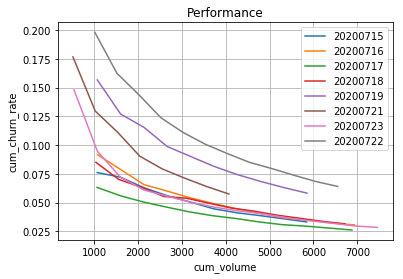

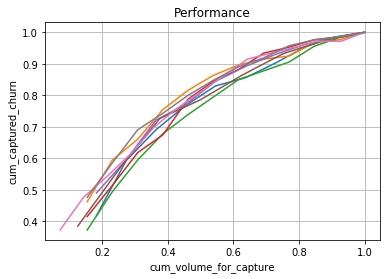

In [12]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()

for closing_day, df in results_dict.items():
    df_pandas = df.select("cum_volume", "cum_churn_rate", "cum_captured_churn", "cum_volume_for_capture").toPandas()
    ax.plot(df_pandas["cum_volume"], df_pandas["cum_churn_rate"], label=closing_day)
    ax2.plot(df_pandas["cum_volume_for_capture"], df_pandas["cum_captured_churn"], label=closing_day)

    
    
    
ax.set(xlabel="cum_volume", ylabel='cum_churn_rate',
       title='Performance')
ax.grid()


ax2.set(xlabel="cum_volume_for_capture", ylabel='cum_captured_churn',
       title='Performance')
ax2.grid()

ax.legend()
plt.show()
    
    